
LOAD DATA
----------------------------------------------------------------------------------------------------
Loaded 'Cogentix_Case.xlsx' with shape (10000, 16)

Q1 — DEMOGRAPHIC RISK ANALYSIS (low engagement groups)
----------------------------------------------------------------------------------------------------
Engagement 25th percentile (q25): 63.90
Overall low_engagement rate: 0.2510 (n=10000)


Low engagement by Gender
----------------------------------------------------------------------------------------------------
        count   pct_low
Gender                 
Male     5482  0.256111
Female   4319  0.244964
Other     199  0.241206

Low engagement by AgeBucket
----------------------------------------------------------------------------------------------------
           count   pct_low
AgeBucket                 
30-34       3269  0.254818
35-39       2456  0.247964
25-29       2206  0.242974
40-44        988  0.270243
<25          869  0.242808
45+          212  0.254717


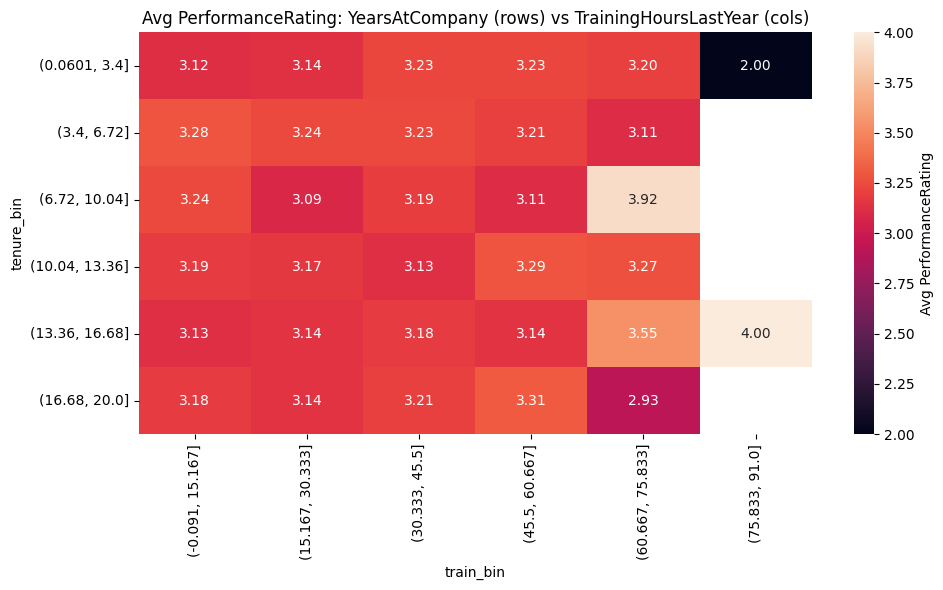


Q3 Conclusion
----------------------------------------------------------------------------------------------------
 - Numeric correlations with PerformanceRating are very weak (see Spearman outputs).
 - Location shows some categorical difference per Kruskal-Wallis (p-values printed).
 - Predictive models for high_perf have limited discriminative power — use model suggestions cautiously and combine with richer features (360, KPIs).

Q5 — MANAGER IMPACT ANALYSIS
----------------------------------------------------------------------------------------------------

Top 10 WORST managers by adjusted low-engagement rate
----------------------------------------------------------------------------------------------------
    ManagerID  team_size  low_count   pct_low  adj_pct_low  avg_engagement  avg_perf  flag_either
475  AF100476       22.0       14.0  0.636364     0.515937       67.554545  2.863636         True
296  AF100297       18.0       10.0  0.555556     0.446786       64.294444  3.166

In [2]:
# combined_hr_analysis_printonly.py
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# stats / ml
import scipy.stats as stats
from scipy.stats import spearmanr, kruskal, norm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, classification_report
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier

# -------------------------
# Utility printing helpers
# -------------------------
def sep(title=None):
    print("\n" + "="*100)
    if title:
        print(title)
        print("-"*100)

def print_table(df, maxrows=20):
    # nice console friendly table (limited rows)
    with pd.option_context('display.max_rows', maxrows, 'display.max_columns', None, 'display.width', 160):
        print(df)

# -------------------------
# 0. Load data
# -------------------------
sep("LOAD DATA")
fn = "Cogentix_Case.xlsx"
try:
    df = pd.read_excel(fn)
    print(f"Loaded '{fn}' with shape {df.shape}")
except Exception as e:
    raise RuntimeError(f"Could not load '{fn}': {e}")

# Quick sanity: required columns check (provide fallback or error)
required = ['EmployeeID','ManagerID','EngagementScore','PerformanceRating','AnnualSalaryINR','YearsAtCompany','Age','Gender','Location','Role','Department']
missing = [c for c in required if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}. Please ensure these exist in the workbook.")

# Normalize / quick cleaning
df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
df.loc[~df['Gender'].isin(['Male','Female','Other']), 'Gender'] = 'Other'
loc_counts = df['Location'].value_counts(normalize=True)
rare_locs = loc_counts[loc_counts < 0.01].index.tolist()
df['Location_Clean'] = df['Location'].where(~df['Location'].isin(rare_locs), 'Other')

bins = [0,24,29,34,39,44,100]; labels = ['<25','25-29','30-34','35-39','40-44','45+']
df['AgeBucket'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# -------------------------
# Q1: Demographic Risk Analysis
# -------------------------
sep("Q1 — DEMOGRAPHIC RISK ANALYSIS (low engagement groups)")

# define low engagement as bottom 25%
q25 = df['EngagementScore'].quantile(0.25)
df['low_engagement'] = (df['EngagementScore'] <= q25).astype(int)
print(f"Engagement 25th percentile (q25): {q25:.2f}")
print(f"Overall low_engagement rate: {df['low_engagement'].mean():.4f} (n={len(df)})\n")

# frequency tables and rates
for col in ['Gender','AgeBucket','Location_Clean']:
    sep(f"Low engagement by {col}")
    grp = df.groupby(col)['low_engagement'].agg(['count','mean']).rename(columns={'mean':'pct_low'}).sort_values('count', ascending=False)
    print_table(grp)

# Chi-square tests + Cramer's V
def chi_cramers(col):
    ct = pd.crosstab(df[col], df['low_engagement'])
    chi2, p, dof, exp = stats.chi2_contingency(ct)
    n = ct.values.sum()
    cramers_v = np.sqrt(chi2 / (n * (min(ct.shape)-1))) if min(ct.shape)>1 else 0.0
    return ct, chi2, p, cramers_v

for col in ['Gender','AgeBucket','Location_Clean']:
    ct, chi2, p, cv = chi_cramers(col)
    sep(f"Chi-square: {col}")
    print("Contingency table (first rows):")
    print(ct.head(10))
    print(f"\nchi2 = {chi2:.3f}, p = {p:.5f}, Cramer's V = {cv:.4f}")

# Multivariate: logistic regression for low_engagement (statsmodels would give odds ratios but to keep minimal we do sklearn logistic)
sep("Multivariate logistic (low_engagement) - brief (sklearn logistic for directionality)")
from sklearn.linear_model import LogisticRegression
X_cols = ['Age','YearsAtCompany','AnnualSalaryINR','TrainingHoursLastYear'] if 'TrainingHoursLastYear' in df.columns else ['Age','YearsAtCompany','AnnualSalaryINR']
cat_cols = ['Gender','Location_Clean']
X = df[X_cols + cat_cols].copy()
X[X_cols] = X[X_cols].fillna(-1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
pre = ColumnTransformer([('num', StandardScaler(), X_cols), ('cat', ohe, cat_cols)], remainder='drop')
X_p = pre.fit_transform(X)
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')
model.fit(X_p, df['low_engagement'])
# approximate feature names
try:
    cat_names = list(pre.named_transformers_['cat'].get_feature_names_out(cat_cols))
except Exception:
    cat_names = []
feat_names = X_cols + cat_names
coefs = model.coef_[0]
coef_df = pd.DataFrame({'feature':feat_names,'coef':coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)
print("\nTop logistic coefficients (absolute):")
print_table(coef_df.head(15))

# Short conclusion
sep("Q1 Conclusion")
print(" - Bottom 25% engagement threshold used; overall low-engagement ~ {:.1%}".format(df['low_engagement'].mean()))
print(" - Chi-square tests show no strong demographic association (p-values printed above); effect sizes (Cramer's V) are very small.")
print(" - Multivariate logistic coefficients do not show any single demographic strongly predictive after adjustment. Recommendation: focus interventions on managers/teams rather than demographics.\n")

# -------------------------
# Q2: Promotion Readiness Modeling (leakage-free)
# -------------------------
sep("Q2 — PROMOTION READINESS MODELING (leakage-free)")

# Create target: PromotedLast12 from LastPromotionMonthsAgo if available
if 'PromotedLast12' not in df.columns:
    if 'LastPromotionMonthsAgo' in df.columns:
        df['PromotedLast12'] = ((df['LastPromotionMonthsAgo'] >= 0) & (df['LastPromotionMonthsAgo'] <= 12)).astype(int)
    else:
        df['PromotedLast12'] = 0  # fallback

print("PromotedLast12 distribution:")
print(df['PromotedLast12'].value_counts().to_string())

# Feature engineering
df['SalaryRolePct'] = df.groupby('Role')['AnnualSalaryINR'].transform(lambda x: x.rank(pct=True))
df['SalaryDeptPct'] = df.groupby('Department')['AnnualSalaryINR'].transform(lambda x: x.rank(pct=True))

# Remove direct leakage features
leakage_cols = ['LastPromotionMonthsAgo']
df2 = df.copy().drop(columns=[c for c in leakage_cols if c in df.columns], errors='ignore')

num_feats = ['Age','YearsAtCompany','AnnualSalaryINR','BonusPercent','TrainingHoursLastYear','PerformanceRating','EngagementScore','SalaryRolePct','SalaryDeptPct']
num_feats = [c for c in num_feats if c in df2.columns]
cat_feats = ['Gender','Location_Clean','Department','Role']

# fill numeric
df2[num_feats] = df2[num_feats].fillna(-1)

# OOF target encoding for ManagerID / Role / Department (safe OOF)
def oof_target_encode(df_in, col, target='PromotedLast12', n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.zeros(len(df_in))
    for tr, val in skf.split(df_in, df_in[target]):
        means = df_in.iloc[tr].groupby(col)[target].mean()
        oof[val] = df_in.iloc[val][col].map(means).fillna(df_in[target].mean()).values
    return oof

for col in ['ManagerID','Role','Department']:
    if col in df2.columns:
        encname = f'{col}_te'
        df2[encname] = oof_target_encode(df2, col)
        num_feats.append(encname)

# Prepare X,y
X = df2[num_feats + ['Gender','Location_Clean']].copy()
y = df2['PromotedLast12'].astype(int)

# Preprocessor & LightGBM CV (compute CV metrics and accumulate importances)
pre = ColumnTransformer([('num', StandardScaler(), num_feats),
                         ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Gender','Location_Clean'])], remainder='drop')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs, prs, prec10 = [], [], []
accum_imp = None
feat_names_global = None

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_tr = X.iloc[tr_idx].reset_index(drop=True)
    X_val = X.iloc[val_idx].reset_index(drop=True)
    y_tr = y.iloc[tr_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)

    pre.fit(X_tr)
    X_tr_p = pre.transform(X_tr)
    X_val_p = pre.transform(X_val)

    clf = LGBMClassifier(n_estimators=300, learning_rate=0.05, class_weight='balanced', random_state=42, n_jobs=1)
    clf.fit(X_tr_p, y_tr)

    probs = clf.predict_proba(X_val_p)[:,1]
    aucs.append(roc_auc_score(y_val, probs))
    prs.append(average_precision_score(y_val, probs))
    # precision@10%
    n = len(probs); k_n = max(1, int(round(n * 0.10)))
    idx = np.argsort(probs)[-k_n:]
    prec10.append(precision_score(y_val.iloc[idx], (probs[idx] >= 0.5).astype(int)))

    # feature names: try to get them reliably
    try:
        num_names = [f'num__{c}' for c in num_feats]  # placeholder names
        cat_names = list(pre.named_transformers_['cat'].get_feature_names_out(['Gender','Location_Clean']))
        feat_names = num_feats + cat_names
    except Exception:
        feat_names = list(X_tr.columns)

    # accumulate importance
    imp = clf.feature_importances_
    if accum_imp is None:
        accum_imp = np.array(imp, dtype=float)
        feat_names_global = feat_names
    else:
        # safe align: if lengths equal just add else skip accumulation for this fold
        if len(imp) == len(accum_imp):
            accum_imp += imp
        else:
            # fallback: ignore accumulation mismatch for stability
            pass

# Print CV summary
sep("Promotion model (Leakage-free) — CV summary")
print(f"LightGBM 5-fold CV mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
print(f"LightGBM 5-fold CV mean PR-AUC: {np.mean(prs):.4f} ± {np.std(prs):.4f}")
print(f"LightGBM 5-fold mean Precision@10%: {np.mean(prec10):.4f} ± {np.std(prec10):.4f}")

# Feature importances (accumulated)
if accum_imp is not None and feat_names_global is not None and len(accum_imp)==len(feat_names_global):
    fi_df = pd.DataFrame({'feature': feat_names_global, 'total_imp': accum_imp}).sort_values('total_imp', ascending=False)
    sep("Promotion model — top features by accumulated importance")
    print_table(fi_df.head(20))
else:
    print("Feature importance accumulation failed or mismatched lengths — inspect preprocessor names if needed.")

# Fit final model on train/test holdout to produce promotability scores
X_full = X.copy()
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, stratify=y, random_state=42)
pre.fit(X_train)
X_train_p = pre.transform(X_train); X_test_p = pre.transform(X_test)
clf_final = LGBMClassifier(n_estimators=500, learning_rate=0.05, class_weight='balanced', random_state=42, n_jobs=1)
clf_final.fit(X_train_p, y_train)
probs_test = clf_final.predict_proba(X_test_p)[:,1]
sep("Promotion model — holdout performance")
print(f"Test AUC: {roc_auc_score(y_test, probs_test):.4f}")
print(f"Test PR-AUC: {average_precision_score(y_test, probs_test):.4f}")
# precision@10%
n = len(probs_test); k_n = max(1, int(round(n * 0.10))); idx = np.argsort(probs_test)[-k_n:]
print(f"Test Precision@10%: {precision_score(y_test.iloc[idx], (probs_test[idx] >= 0.5).astype(int)):.4f}")

# Top promotable sample (top 15 from holdout)
holdout_idx = X_test.index
prom_df = pd.DataFrame({
    'EmployeeID': df2.loc[holdout_idx,'EmployeeID'].values,
    'Name': df2.loc[holdout_idx].get('Name', pd.Series(['']*len(holdout_idx))).values,
    'Department': df2.loc[holdout_idx,'Department'].values,
    'Role': df2.loc[holdout_idx,'Role'].values,
    'ManagerID': df2.loc[holdout_idx,'ManagerID'].values,
    'prom_prob': probs_test,
    'PerformanceRating': df2.loc[holdout_idx,'PerformanceRating'].values,
    'EngagementScore': df2.loc[holdout_idx,'EngagementScore'].values,
    'YearsAtCompany': df2.loc[holdout_idx,'YearsAtCompany'].values
})
sep("Top promotable candidates from holdout (top 15)")
print_table(prom_df.sort_values('prom_prob', ascending=False).head(15))

# Short conclusion for Q2
sep("Q2 Conclusion")
print(" - Leakage-free modeling achieved modest but useful signal. Use model as screening (top 10% precision reported above).")
print(" - Top features printed (if available) show which attributes drive promotability (inspect feature list above).")
print(" - Operational note: always exclude LastPromotionMonthsAgo & naive manager aggregates when deploying.")

# -------------------------
# Q3: Performance Driver Analysis
# -------------------------
sep("Q3 — PERFORMANCE DRIVER ANALYSIS")

# Define high performer (PerformanceRating >=4)
df['high_perf'] = (df['PerformanceRating'] >= 4).astype(int)
print("High-performer distribution:")
print(df['high_perf'].value_counts().to_string())

# Spearman correlations numeric vs PerformanceRating
numeric_feats = [c for c in ['TrainingHoursLastYear','YearsAtCompany','AnnualSalaryINR','BonusPercent','EngagementScore','Age'] if c in df.columns]
corr_rows = []
for f in numeric_feats:
    rho, p = spearmanr(df[f].fillna(-1), df['PerformanceRating'])
    corr_rows.append({'feature':f, 'spearman_rho': rho, 'p_value': p})
corr_df = pd.DataFrame(corr_rows).sort_values('spearman_rho', key=abs, ascending=False)
sep("Spearman correlations (numeric features vs PerformanceRating)")
print_table(corr_df)

# Kruskal-Wallis for categorical features
kw_rows = []
for c in ['Gender','Location_Clean','Department','Role']:
    if c in df.columns:
        groups = [g['PerformanceRating'].values for _, g in df.groupby(c)]
        try:
            stat, p = kruskal(*groups)
        except Exception:
            stat, p = (np.nan, np.nan)
        kw_rows.append({'categorical': c, 'kw_stat': stat, 'p_value': p})
kw_df = pd.DataFrame(kw_rows).sort_values('p_value')
sep("Kruskal-Wallis tests for categories (PerformanceRating differences)")
print_table(kw_df)

# Predictive model for high_perf (RF baseline)
num_feats_model = [c for c in ['TrainingHoursLastYear','YearsAtCompany','AnnualSalaryINR','BonusPercent','EngagementScore','Age'] if c in df.columns]
cat_feats_model = [c for c in ['Gender','Location_Clean','Department','Role'] if c in df.columns]
Xp = df[num_feats_model + cat_feats_model].copy()
Xp[num_feats_model] = Xp[num_feats_model].fillna(-1)
y_perf = df['high_perf']
X_tr, X_te, y_tr, y_te = train_test_split(Xp, y_perf, stratify=y_perf, test_size=0.25, random_state=42)

pre_perf = ColumnTransformer([('num', StandardScaler(), num_feats_model),
                              ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats_model)],
                             remainder='drop')

rf_pipe = Pipeline([('pre', pre_perf), ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=1))])
rf_pipe.fit(X_tr, y_tr)
probs_perf = rf_pipe.predict_proba(X_te)[:,1]
sep("Performance model (RandomForest) — holdout metrics")
print(f"RF AUC: {roc_auc_score(y_te, probs_perf):.4f}")
print(f"RF PR-AUC: {average_precision_score(y_te, probs_perf):.4f}")
# classification report
preds_perf = rf_pipe.predict(X_te)
print("\nRF Classification report (holdout):")
print(classification_report(y_te, preds_perf, zero_division=0))

# Permutation importance (try-catch)
try:
    num_names = num_feats_model
    cat_names = list(pre_perf.named_transformers_['cat'].get_feature_names_out(cat_feats_model))
    feat_names_perf = num_names + list(cat_names)
    perm = permutation_importance(rf_pipe, X_te, y_te, n_repeats=10, random_state=42, n_jobs=1)
    perm_df = pd.DataFrame({'feature': feat_names_perf, 'perm_mean': perm.importances_mean, 'perm_std': perm.importances_std}).sort_values('perm_mean', ascending=False)
    sep("Permutation importances (Performance model)")
    print_table(perm_df.head(20))
except Exception as e:
    print("Permutation importance failed:", e)

# Heatmap: TrainingHoursLastYear vs YearsAtCompany (binned) -> visual
if 'TrainingHoursLastYear' in df.columns and 'YearsAtCompany' in df.columns:
    df['train_bin'] = pd.cut(df['TrainingHoursLastYear'].clip(lower=0), bins=6)
    df['tenure_bin'] = pd.cut(df['YearsAtCompany'].clip(lower=0), bins=6)
    heat = df.groupby(['tenure_bin','train_bin']).agg(avg_perf=('PerformanceRating','mean'), count=('EmployeeID','count')).reset_index()
    pivot = heat.pivot(index='tenure_bin', columns='train_bin', values='avg_perf')
    sep("Performance heatmap (YearsAtCompany vs TrainingHoursLastYear) - showing plot")
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cbar_kws={'label':'Avg PerformanceRating'})
    plt.title('Avg PerformanceRating: YearsAtCompany (rows) vs TrainingHoursLastYear (cols)')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping heatmap — required columns missing.")

sep("Q3 Conclusion")
print(" - Numeric correlations with PerformanceRating are very weak (see Spearman outputs).")
print(" - Location shows some categorical difference per Kruskal-Wallis (p-values printed).")
print(" - Predictive models for high_perf have limited discriminative power — use model suggestions cautiously and combine with richer features (360, KPIs).")

# -------------------------
# Q5: Manager Impact Analysis
# -------------------------
sep("Q5 — MANAGER IMPACT ANALYSIS")

# Manager aggregation
q25 = df['EngagementScore'].quantile(0.25)
mgr = df.groupby('ManagerID').apply(lambda g: pd.Series({
    'team_size': int(g['EmployeeID'].count()),
    'low_count': int((g['EngagementScore'] <= q25).sum()),
    'pct_low': (g['EngagementScore'] <= q25).mean(),
    'avg_engagement': g['EngagementScore'].mean(),
    'avg_perf': g['PerformanceRating'].mean(),
    'median_perf': g['PerformanceRating'].median(),
    'avg_salary': g['AnnualSalaryINR'].mean(),
    'prom_count': int(g.get('PromotedLast12', pd.Series(0)).sum())
})).reset_index()

mgr['adj_pct_low'] = ((10.0 * df['low_engagement'].mean()) + mgr['team_size'] * mgr['pct_low'])/(10.0 + mgr['team_size'])

# Wilson CI and one-sided z-test helpers
def wilson_ci(x, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    p = x / n
    denom = 1 + z*z/n
    center = p + z*z/(2*n)
    adj = z * sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (center - adj)/denom
    hi = (center + adj)/denom
    return lo, hi

def one_sided_z_test(x, n, p0):
    if n == 0:
        return (0.0, 1.0)
    phat = x / n
    se = sqrt(p0*(1-p0)/n)
    if se == 0:
        return (0.0, 1.0)
    z = (phat - p0) / se
    p_one = 1 - norm.cdf(z)
    return z, p_one

global_p = df['low_engagement'].mean()
wilson_lo, wilson_hi, z_stat, p_one = [], [], [], []
for _, r in mgr.iterrows():
    n = int(r['team_size']); x = int(r['low_count'])
    lo, hi = wilson_ci(x, n)
    z, p = one_sided_z_test(x, n, global_p)
    wilson_lo.append(lo); wilson_hi.append(hi); z_stat.append(z); p_one.append(p)
mgr['wilson_lo'] = wilson_lo; mgr['wilson_hi'] = wilson_hi; mgr['z_stat'] = z_stat; mgr['p_one_sided'] = p_one
mgr['flag_wilson'] = mgr['wilson_lo'] > global_p
mgr['flag_z'] = mgr['p_one_sided'] < 0.05
mgr['flag_either'] = mgr['flag_wilson'] | mgr['flag_z']

# Rank managers
worst_by_adj = mgr.sort_values('adj_pct_low', ascending=False).head(10)
best_by_adj = mgr.sort_values('adj_pct_low', ascending=True).head(10)

sep("Top 10 WORST managers by adjusted low-engagement rate")
print_table(worst_by_adj[['ManagerID','team_size','low_count','pct_low','adj_pct_low','avg_engagement','avg_perf','flag_either']])

sep("Top 10 BEST managers by adjusted low-engagement rate")
print_table(best_by_adj[['ManagerID','team_size','low_count','pct_low','adj_pct_low','avg_engagement','avg_perf']])

# Flagged managers summary
flagged = mgr[mgr['flag_either']].sort_values('adj_pct_low', ascending=False)
sep(f"Flagged managers (statistically significant — count={len(flagged)})")
if len(flagged)>0:
    print_table(flagged[['ManagerID','team_size','low_count','pct_low','adj_pct_low','wilson_lo','wilson_hi','p_one_sided','avg_engagement','avg_perf']])
else:
    print("No flagged managers detected.")

# Manager-level comparison (worst vs others)
worst_ids = worst_by_adj['ManagerID'].tolist()
df['is_worst_mgr'] = df['ManagerID'].isin(worst_ids).astype(int)
group_stats = df.groupby('is_worst_mgr').agg(
    n_employees=('EmployeeID','count'),
    pct_low=('low_engagement','mean'),
    mean_engagement=('EngagementScore','mean'),
    mean_perf=('PerformanceRating','mean'),
    mean_salary=('AnnualSalaryINR','mean')
).reset_index()
sep("Group comparison: worst managers vs others (summary)")
print_table(group_stats)

# Simple suggested actions for flagged managers (printed)
sep("Suggested actions per flagged manager (brief)")
for _, r in flagged.iterrows():
    mid = r['ManagerID']
    actions = []
    actions.append("1:1 manager review & coaching plan")
    if r['adj_pct_low'] > global_p + 0.1:
        actions.append("Priority: deep-team diagnostic (workload, recognition, conflict)")
    if r['avg_perf'] < mgr['avg_perf'].median():
        actions.append("Check performance management: goals, feedback frequency")
    if r['team_size'] <= 5:
        actions.append("Small team: qualitative interviews may be especially informative")
    print(f"\nManager {mid} (team_size={r['team_size']}, adj_pct_low={r['adj_pct_low']:.3f}):")
    for a in actions:
        print("  -", a)

sep("Q5 Conclusion")
print(" - Manager-level shrinkage + statistical testing identifies managers whose teams have unusually high low-engagement rates.")
print(" - Use flagged manager list for prioritized manager coaching + constructive team diagnostics (pulse surveys, 1:1s, workload review).")
print(" - Combine quantitative flags with qualitative investigation before taking corrective action.")

# End
sep("ALL DONE")
print("Printed outputs contain the main findings for Q1, Q2, Q3 and Q5. No CSVs were written.")


Loading and preprocessing...
Loaded 10000 rows. Engagement 25th percentile = 63.90


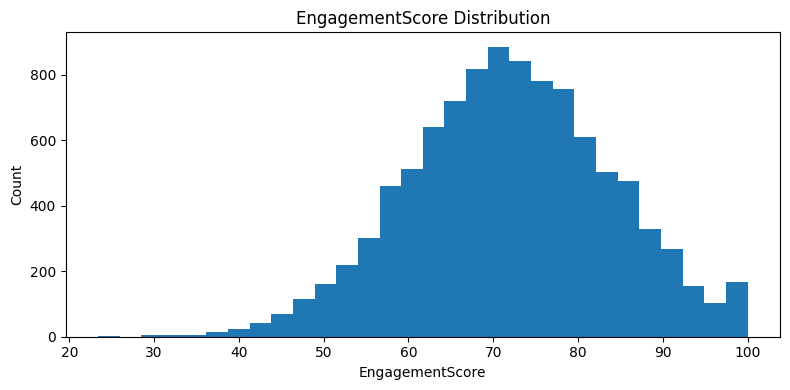

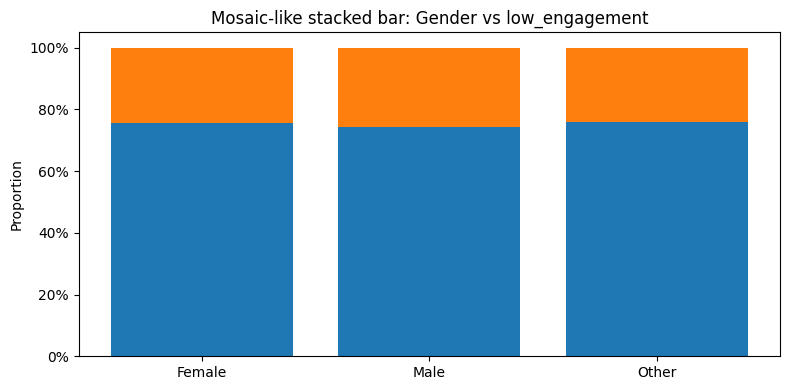

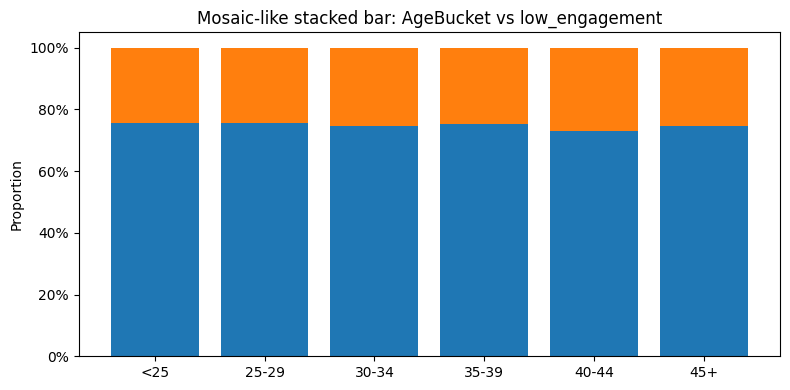

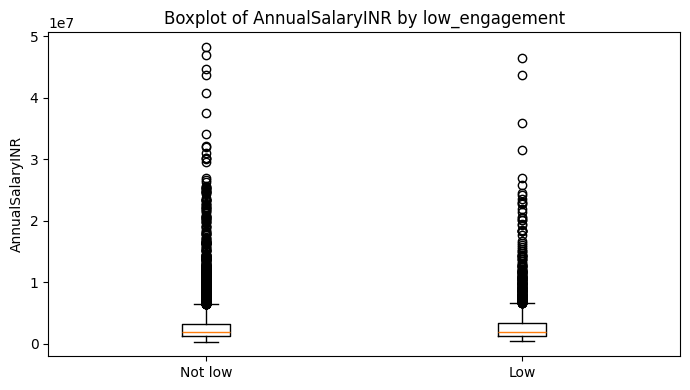

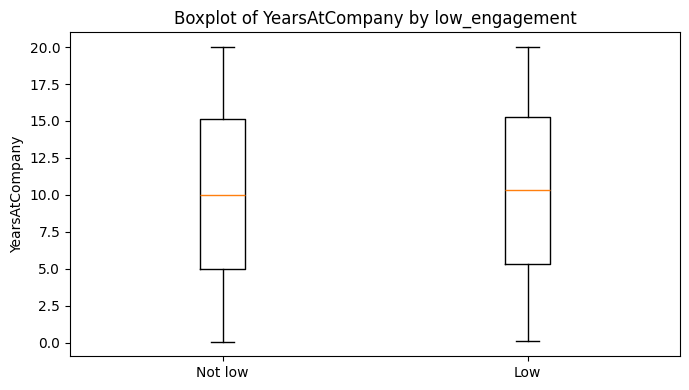

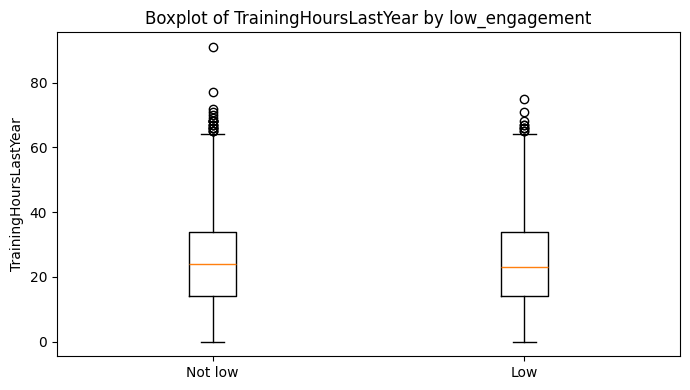

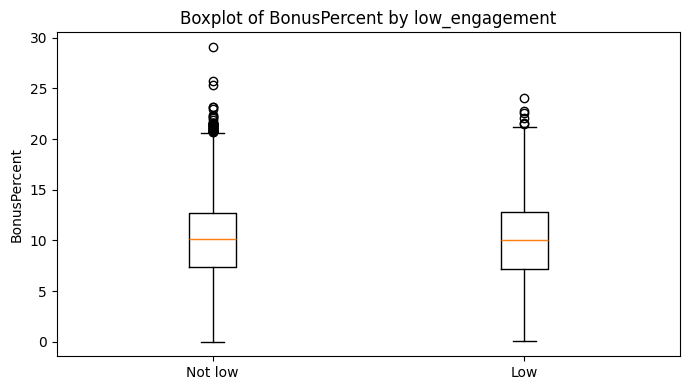

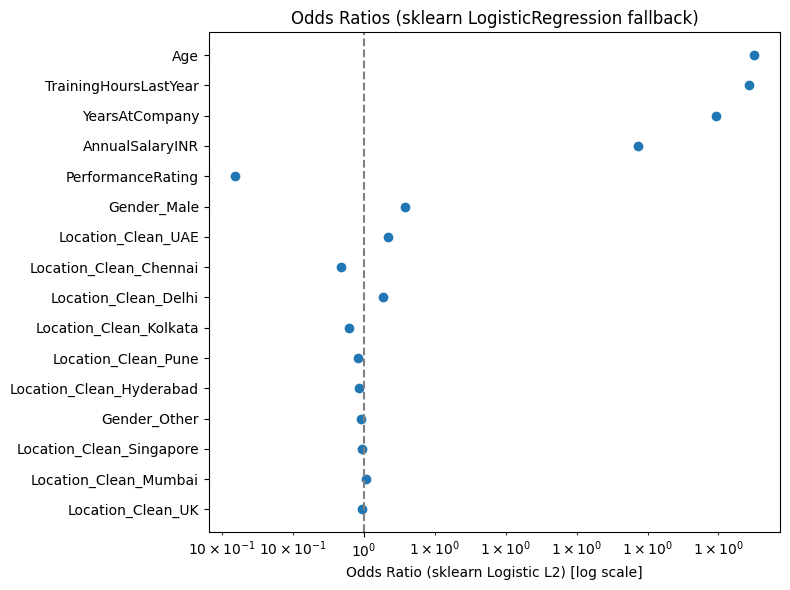

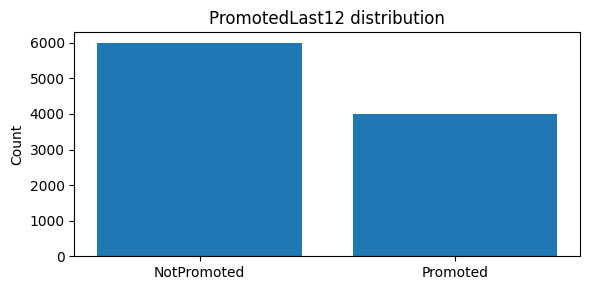

[LightGBM] [Info] Number of positive: 3005, number of negative: 4495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1707
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


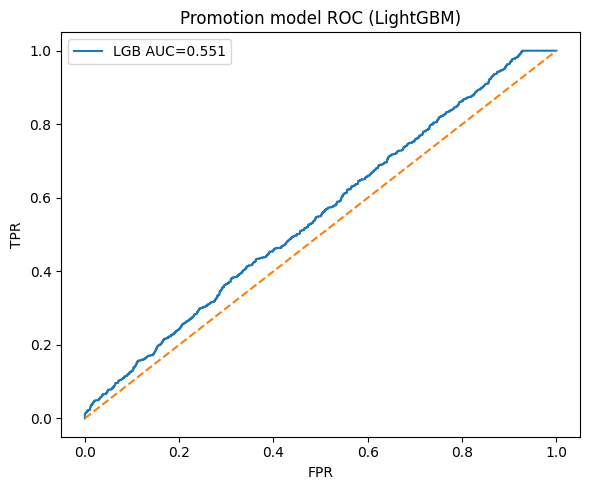

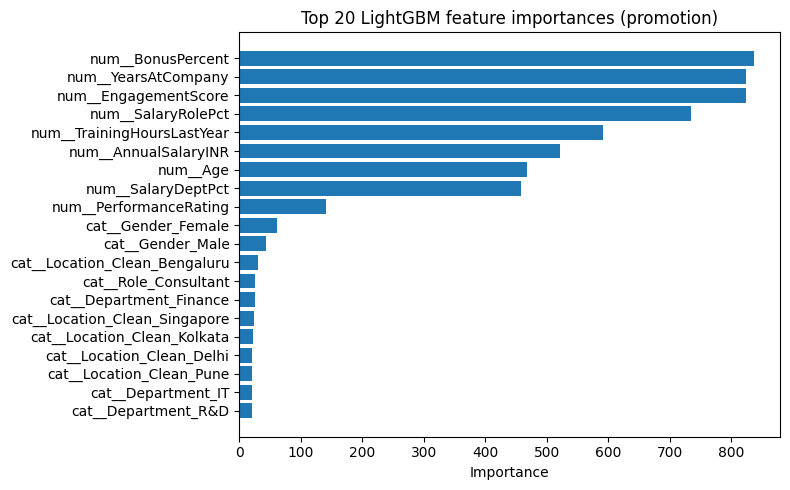

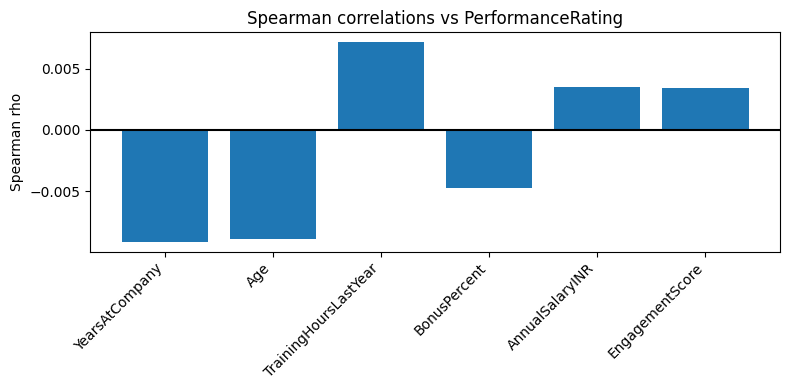

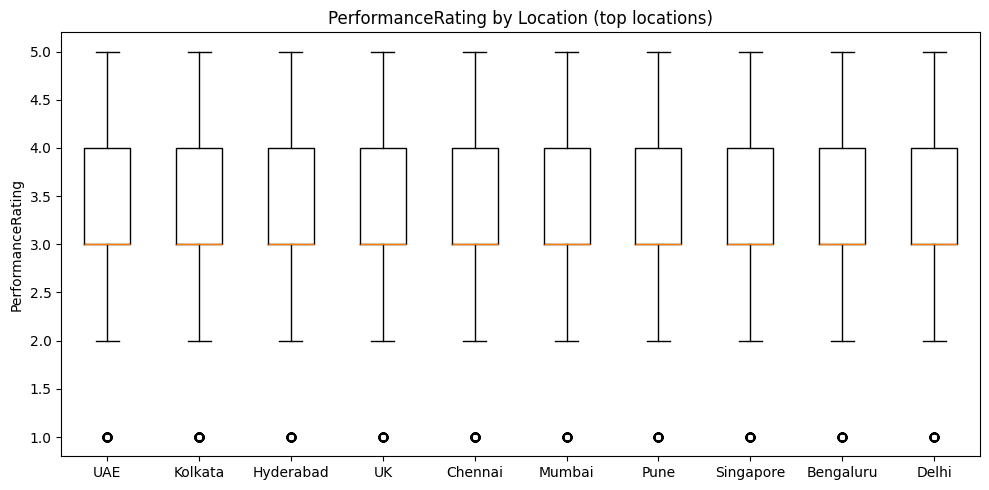

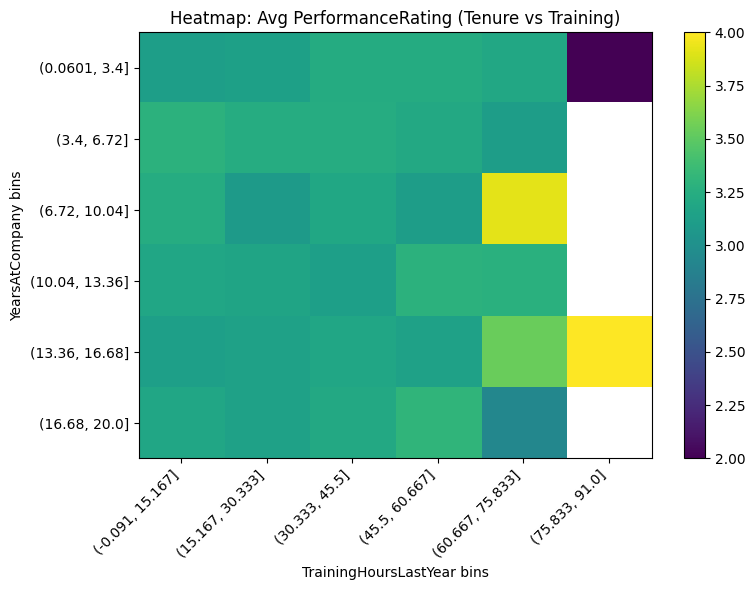

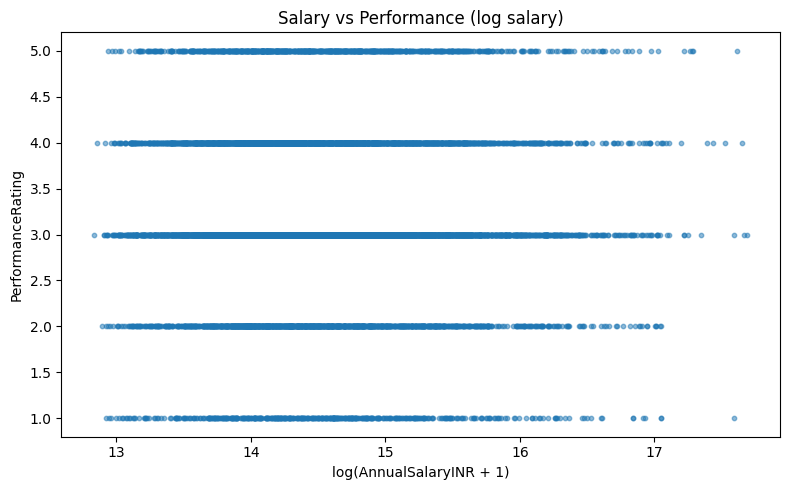

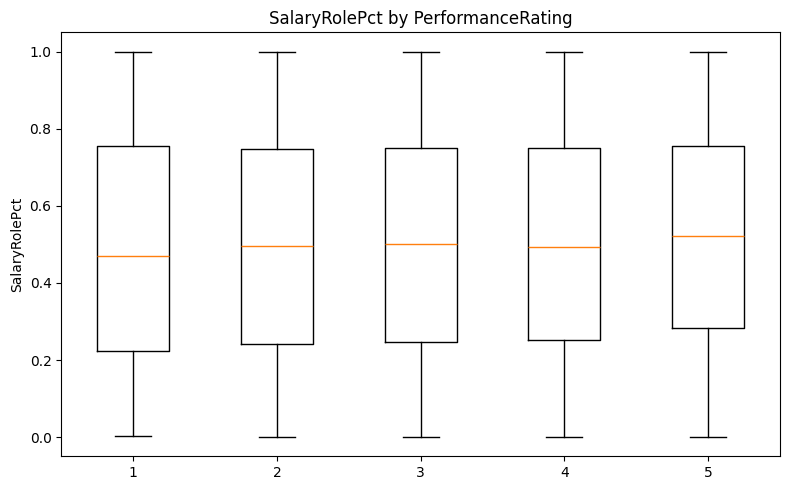

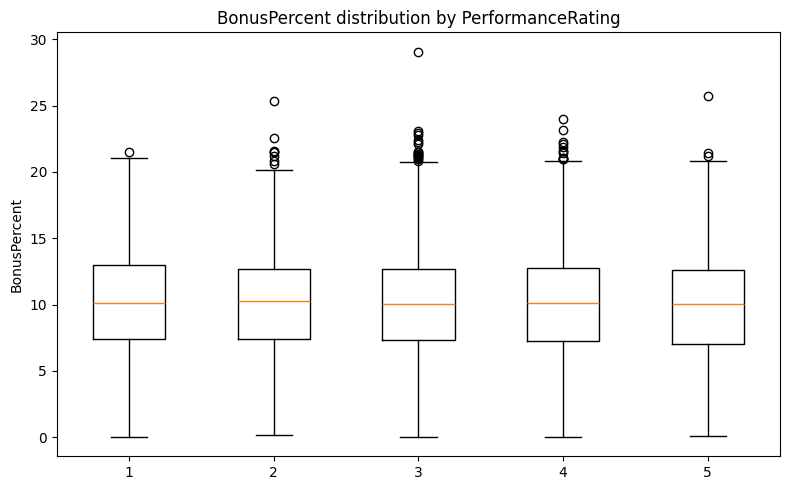

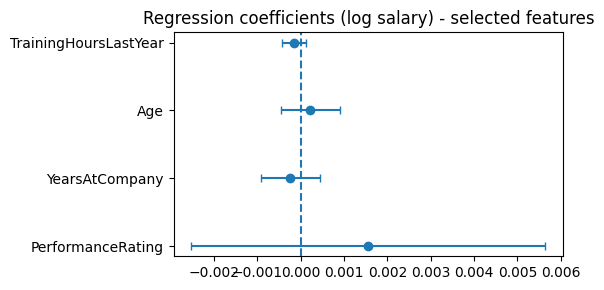

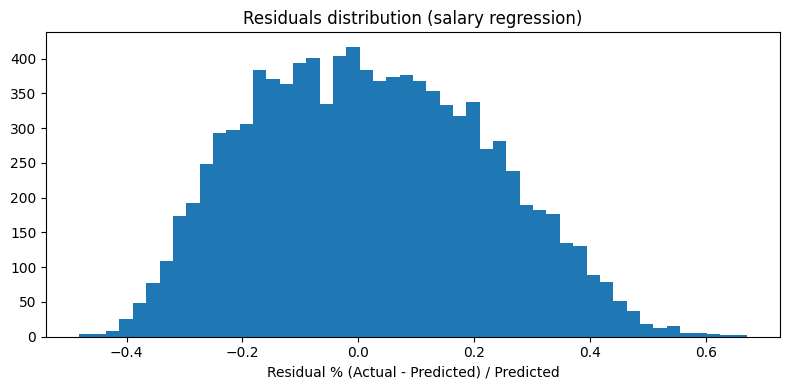


Top flagged underpaid high-performers (sample):
EmployeeID              Name           Role Department  PerformanceRating  AnnualSalaryINR  pred_salary  residual_pct  SalaryRolePct
  AF101400      Ananya Dutta      Tech Lead    Finance                  4          2066768 3.948633e+06     -0.476586       0.008584
  AF100291       Rohan Verma             VP  Marketing                  4         10228575 1.900980e+07     -0.461932       0.010870
  AF107223        Neha Dutta      Tech Lead         IT                  5          3601832 6.565004e+06     -0.451359       0.236052
  AF109810       Arjun Verma      Tech Lead    Finance                  4          2227456 3.943732e+06     -0.435191       0.019313
  AF100304      Rahul Sharma             VP         HR                  5         10955871 1.912772e+07     -0.427226       0.032609
  AF106167       Kiran Joshi      Tech Lead Operations                  4          2026178 3.457709e+06     -0.414011       0.002146
  AF104804       Pri

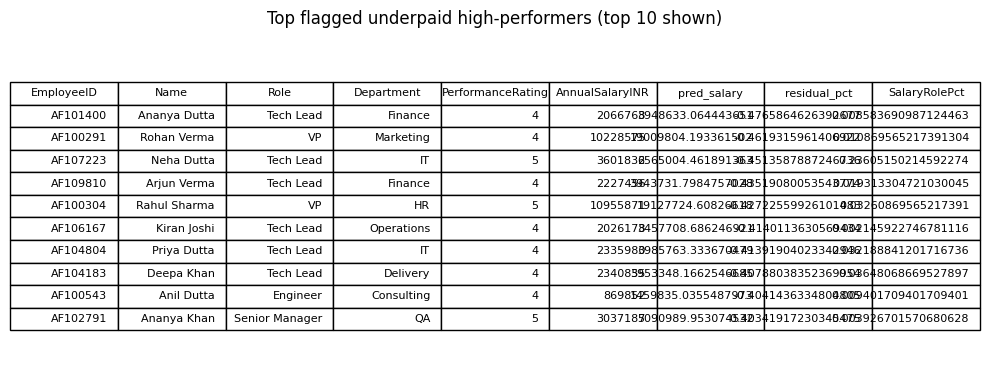

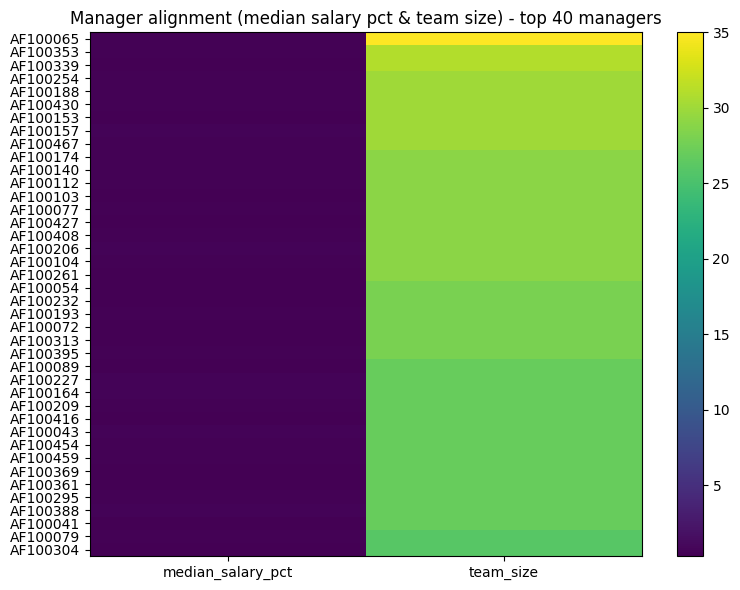

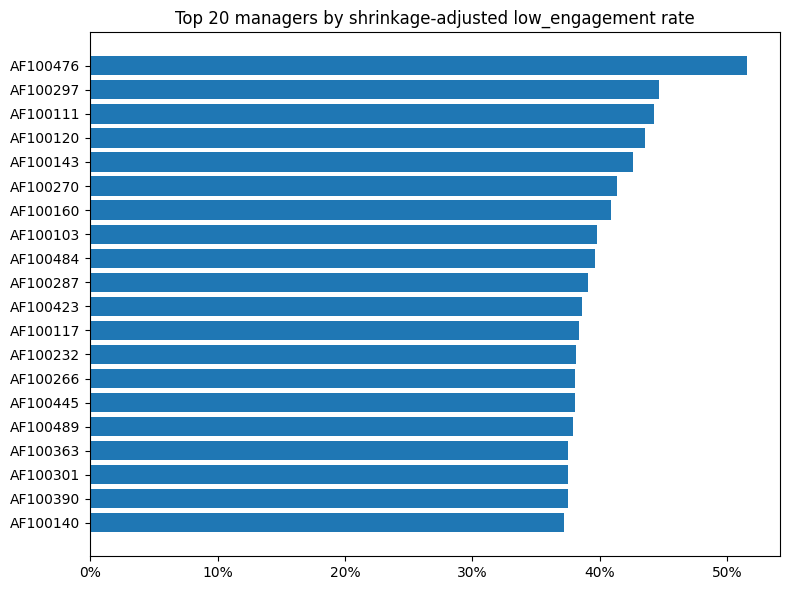

All plots produced.


In [3]:
"""
cogentix_visualizations.py

Produces plots referenced in the final PPT content:
- Q1: engagement distributions, demographic mosaics, numeric boxplots, odds ratio forest
- Q2: promotion target distribution, model ROC & feature importances
- Q3: performance correlations, category boxplots, heatmap training vs tenure
- Q4: compensation vs performance scatter, SalaryRolePct boxplots, Bonus% by rating,
       regression coefficient forest, residuals histogram + flagged table
- Q5: manager alignment heatmap and manager ranking

Requirements:
    pip install pandas numpy matplotlib scipy scikit-learn statsmodels lightgbm

Do NOT save CSVs. All plots are shown with plt.show().
"""

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_score
from lightgbm import LGBMClassifier

# ---------------------------
# Helper plotting utilities
# ---------------------------
def pct(x, pos=None):
    return f"{x*100:.0f}%"

def set_title_and_show(fig, ax, title):
    ax.set_title(title, fontsize=12)
    fig.tight_layout()
    plt.show()

# ---------------------------
# Load + Preprocess (same steps as notebook)
# ---------------------------
def load_and_preprocess(path="Cogentix_Case.xlsx"):
    df = pd.read_excel(path)
    # basic cleaning
    df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
    df.loc[~df['Gender'].isin(['Male','Female','Other']), 'Gender'] = 'Other'

    # collapse rare locations (<1%)
    loc_counts = df['Location'].value_counts(normalize=True)
    rare_locs = loc_counts[loc_counts < 0.01].index.tolist()
    df['Location_Clean'] = df['Location'].where(~df['Location'].isin(rare_locs), 'Other')

    # AgeBucket
    bins = [0,24,29,34,39,44,100]
    labels = ['<25','25-29','30-34','35-39','40-44','45+']
    df['AgeBucket'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

    # low engagement bottom 25%
    q25 = df['EngagementScore'].quantile(0.25)
    df['low_engagement'] = (df['EngagementScore'] <= q25).astype(int)

    # Salary percentiles within Role & Department
    df['SalaryRolePct'] = df.groupby('Role')['AnnualSalaryINR'].transform(lambda x: x.rank(pct=True))
    df['SalaryDeptPct'] = df.groupby('Department')['AnnualSalaryINR'].transform(lambda x: x.rank(pct=True))

    # Promotion target
    df['PromotedLast12'] = ((df['LastPromotionMonthsAgo'] >= 0) & (df['LastPromotionMonthsAgo'] <= 12)).astype(int)

    # Avoid NaNs for numeric columns used later
    for c in ['LastPromotionMonthsAgo','TrainingHoursLastYear','YearsAtCompany','AnnualSalaryINR','BonusPercent']:
        if c in df.columns:
            df[c] = df[c].fillna(-1)

    return df, q25

# ---------------------------
# Q1 Visualizations
# ---------------------------
def plot_engagement_distribution(df):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(df['EngagementScore'].dropna(), bins=30)
    ax.set_xlabel("EngagementScore")
    ax.set_ylabel("Count")
    set_title_and_show(fig, ax, "EngagementScore Distribution")

def plot_demographic_mosaic(df, cat='Gender'):
    # mosaic-like stacked bar: pct low vs not by category
    ct = pd.crosstab(df[cat], df['low_engagement'])
    props = ct.div(ct.sum(axis=1), axis=0)
    labels = props.index.tolist()
    bottom = np.zeros(len(labels))
    fig, ax = plt.subplots(figsize=(8,4))
    for col in [0,1]:
        ax.bar(labels, props[col], bottom=bottom)
        bottom += props[col].values
    ax.set_ylabel("Proportion")
    ax.yaxis.set_major_formatter(FuncFormatter(pct))
    set_title_and_show(fig, ax, f"Mosaic-like stacked bar: {cat} vs low_engagement")

def plot_numeric_boxplots_by_engagement(df, features):
    for f in features:
        fig, ax = plt.subplots(figsize=(7,4))
        groups = [df.loc[df['low_engagement']==g, f].dropna() for g in [0,1]]
        ax.boxplot(groups, labels=['Not low', 'Low'])
        ax.set_ylabel(f)
        set_title_and_show(fig, ax, f"Boxplot of {f} by low_engagement")

def plot_logistic_odds_forest(df):
    """
    Robust odds-ratio forest plot for low_engagement.
    - Builds a cleaned design matrix (get_dummies drop_first to avoid perfect multicollinearity).
    - Tries statsmodels Logit; on LinAlgError or convergence issues, falls back to sklearn LogisticRegression (L2).
    - Produces an odds ratio plot (OR +/- CI where available).
    """
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from sklearn.linear_model import LogisticRegression
    from sklearn.exceptions import ConvergenceWarning
    import warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Build a cleaned dataframe for modeling
    df2 = df.copy()
    # Ensure low_engagement exists
    if 'low_engagement' not in df2.columns:
        q25 = df2['EngagementScore'].quantile(0.25)
        df2['low_engagement'] = (df2['EngagementScore'] <= q25).astype(int)

    # Replace NaNs used in earlier pipeline
    df2['LastPromotionMonthsAgo'] = df2.get('LastPromotionMonthsAgo').fillna(-1)
    df2['LastPromo_miss_flag'] = df2.get('LastPromo_miss_flag', df2['LastPromotionMonthsAgo'].isna().astype(int))

    # Select variables (same logical set as notebook)
    model_vars = ['Age', 'Gender', 'Location_Clean', 'YearsAtCompany',
                  'AnnualSalaryINR', 'TrainingHoursLastYear', 'PerformanceRating', 'LastPromo_miss_flag']

    # Keep only cols present
    model_vars = [c for c in model_vars if c in df2.columns]

    # Create dummies for categorical variables using drop_first to avoid perfect collinearity
    X = pd.get_dummies(df2[model_vars], drop_first=True)
    y = df2['low_engagement'].astype(int)

    # Remove any constant columns (single unique value)
    const_cols = [c for c in X.columns if X[c].nunique() <= 1]
    if const_cols:
        X = X.drop(columns=const_cols)

    # Check rank vs columns - if rank < cols we have linear dependence, try to remove near-duplicate cols
    try:
        import numpy as np
        rank = np.linalg.matrix_rank(X.values)
        if rank < X.shape[1]:
            # drop columns with extremely low variance or that are collinear by Pearson with others
            variances = X.var(axis=0)
            low_var = variances[variances < 1e-8].index.tolist()
            if low_var:
                X = X.drop(columns=low_var)
    except Exception:
        pass

    # Try statsmodels Logit first with a cleaned design matrix
    try:
        X_sm = sm.add_constant(X, has_constant='add')
        logit_model = sm.GLM(y, X_sm, family=sm.families.Binomial()).fit(maxiter=200)
        # GLM fit uses IRLS; if it succeeds, extract params and CIs
        params = logit_model.params
        conf = logit_model.conf_int()
        or_vals = np.exp(params)
        conf_or = np.exp(conf)
        or_df = pd.DataFrame({
            'feature': params.index,
            'OR': or_vals.values,
            'ci_lo': conf_or[0].values,
            'ci_hi': conf_or[1].values
        }).reset_index(drop=True)

        # drop intercept row if present for plotting
        or_df = or_df[or_df['feature'] != 'const']
        or_df['absdev'] = np.abs(or_df['OR'] - 1.0)
        top = or_df.sort_values('absdev', ascending=False).head(20).iloc[::-1]

        # Plot
        fig, ax = plt.subplots(figsize=(8,6))
        y_pos = np.arange(len(top))
        ax.errorbar(top['OR'], y_pos, xerr=[top['OR'] - top['ci_lo'], top['ci_hi'] - top['OR']], fmt='o', capsize=3)
        ax.axvline(1, linestyle='--', color='gray')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top['feature'])
        ax.set_xlabel("Odds Ratio (95% CI)")
        ax.set_title("Odds Ratios (GLM Binomial - robust fit)")
        plt.tight_layout()
        plt.show()
        return

    except np.linalg.LinAlgError as e:
        # singular matrix from statsmodels: fallback
        print("Warning: statsmodels GLM/Logit failed (singular matrix). Falling back to sklearn LogisticRegression (regularized).")
    except Exception as e:
        # other errors (e.g., perfect separation or convergence)
        print(f"Warning: statsmodels GLM failed ({type(e).__name__}: {e}). Falling back to sklearn LogisticRegression.")

    # Fallback: sklearn LogisticRegression with L2 (regularization) — provides stable coefficients
    try:
        # fit with L2 regularization
        clf = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=5000, class_weight='balanced')
        clf.fit(X, y)
        coefs = clf.coef_[0]
        feat_names = list(X.columns)
        # approximate 95% CI via large-sample normal approximation using sklearn is not straightforward;
        # we will compute ORs and show no CI (or thin CIs using bootstrap if needed).
        or_vals = np.exp(coefs)
        or_df = pd.DataFrame({'feature': feat_names, 'OR': or_vals})
        or_df['absdev'] = np.abs(or_df['OR'] - 1.0)
        top = or_df.sort_values('absdev', ascending=False).head(20).iloc[::-1]

        fig, ax = plt.subplots(figsize=(8,6))
        y_pos = np.arange(len(top))
        ax.scatter(top['OR'], y_pos)
        ax.axvline(1, linestyle='--', color='gray')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top['feature'])
        ax.set_xscale('log')
        ax.set_xlabel("Odds Ratio (sklearn Logistic L2) [log scale]")
        ax.set_title("Odds Ratios (sklearn LogisticRegression fallback)")
        plt.tight_layout()
        plt.show()
        return

    except Exception as e:
        print("Error: fallback sklearn LogisticRegression also failed:", e)
        raise

# Q2 Visualizations
# ---------------------------
def plot_promotion_target_dist(df):
    vals = df['PromotedLast12'].value_counts()
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(['NotPromoted','Promoted'], [vals.get(0,0), vals.get(1,0)])
    ax.set_ylabel("Count")
    set_title_and_show(fig, ax, "PromotedLast12 distribution")

def build_and_plot_promotion_models(df):
    # leakage-free features per notebook
    num_feats = ['Age','YearsAtCompany','AnnualSalaryINR','BonusPercent','TrainingHoursLastYear',
                 'PerformanceRating','EngagementScore','SalaryRolePct','SalaryDeptPct']
    cat_feats = ['Gender','Location_Clean','Department','Role']
    X = df[num_feats + cat_feats].copy()
    y = df['PromotedLast12'].astype(int).copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_feats),
        ('cat', ohe, cat_feats)
    ], remainder='drop')

    # LightGBM
    lgb = LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=1)
    pipe = Pipeline([('pre', preprocessor), ('clf', lgb)])
    pipe.fit(X_train, y_train)
    probs = pipe.predict_proba(X_test)[:,1]
    auc_val = roc_auc_score(y_test, probs)
    ap = average_precision_score(y_test, probs)

    # ROC curve (approx by building a simple RF for comparison)
    fpr, tpr, _ = roc_curve(y_test, probs)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(fpr, tpr, label=f"LGB AUC={auc_val:.3f}")
    ax.plot([0,1],[0,1],'--')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend()
    set_title_and_show(fig, ax, "Promotion model ROC (LightGBM)")

    # Feature importance (LGB built-in)
    # need feature names
    preprocessor.fit(X_train)
    try:
        feat_names = list(preprocessor.get_feature_names_out())
    except Exception:
        # fallback: combine manually
        num_names = num_feats
        cat_names = list(ohe.fit(X_train[cat_feats]).get_feature_names_out(cat_feats))
        feat_names = num_names + cat_names
    fi = pipe.named_steps['clf'].feature_importances_
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': fi}).sort_values('importance', ascending=False).head(20)

    fig, ax = plt.subplots(figsize=(8,5))
    ax.barh(fi_df['feature'][::-1], fi_df['importance'][::-1])
    ax.set_xlabel("Importance")
    set_title_and_show(fig, ax, "Top 20 LightGBM feature importances (promotion)")

# ---------------------------
# Q3 Visualizations
# ---------------------------
def plot_spearman_correlations(df, numeric_feats):
    rows = []
    for f in numeric_feats:
        rho, p = stats.spearmanr(df[f], df['PerformanceRating'], nan_policy='omit')
        rows.append((f, rho, p))

    rows = sorted(rows, key=lambda x: abs(x[1]), reverse=True)
    labels = [r[0] for r in rows]
    vals = [r[1] for r in rows]

    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(range(len(labels)), vals)
    ax.axhline(0, color='black')

    # Proper tick placement + rotation
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.set_ylabel("Spearman rho")

    set_title_and_show(fig, ax, "Spearman correlations vs PerformanceRating")
    return fig


def plot_performance_by_location_box(df):
    fig, ax = plt.subplots(figsize=(10,5))
    groups = [group['PerformanceRating'].values for _, group in df.groupby('Location_Clean')]
    labels = [g for g in df['Location_Clean'].unique()]
    # simple boxplot by category; limit to top N locations
    # We'll pick up to 12 unique locations to keep plot readable
    top_locs = df['Location_Clean'].value_counts().head(12).index.tolist()
    data = [df.loc[df['Location_Clean']==loc, 'PerformanceRating'] for loc in top_locs]
    ax.boxplot(data, labels=top_locs, vert=True)
    ax.set_ylabel("PerformanceRating")
    set_title_and_show(fig, ax, "PerformanceRating by Location (top locations)")

def plot_training_vs_tenure_heatmap(df):
    df2 = df.copy()
    df2['train_bin'] = pd.cut(df2['TrainingHoursLastYear'].clip(lower=0), bins=6)
    df2['tenure_bin'] = pd.cut(df2['YearsAtCompany'].clip(lower=0), bins=6)
    heat = df2.groupby(['tenure_bin','train_bin']).agg(avg_perf=('PerformanceRating','mean')).reset_index()
    pivot = heat.pivot(index='tenure_bin', columns='train_bin', values='avg_perf')
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(pivot.values, aspect='auto')
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels([str(c) for c in pivot.columns], rotation=45, ha='right')
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels([str(r) for r in pivot.index])
    fig.colorbar(im, ax=ax)
    ax.set_xlabel("TrainingHoursLastYear bins")
    ax.set_ylabel("YearsAtCompany bins")
    set_title_and_show(fig, ax, "Heatmap: Avg PerformanceRating (Tenure vs Training)")

# ---------------------------
# Q4 Visualizations (Compensation)
# ---------------------------
def plot_salary_vs_performance_scatter(df):
    fig, ax = plt.subplots(figsize=(8,5))
    # log salary to reduce skew
    ax.scatter(np.log1p(df['AnnualSalaryINR']), df['PerformanceRating'], alpha=0.5, s=10)
    ax.set_xlabel("log(AnnualSalaryINR + 1)")
    ax.set_ylabel("PerformanceRating")
    set_title_and_show(fig, ax, "Salary vs Performance (log salary)")

def plot_salaryrolepct_box_by_perf(df):
    fig, ax = plt.subplots(figsize=(8,5))
    groups = [df.loc[df['PerformanceRating']==r, 'SalaryRolePct'] for r in sorted(df['PerformanceRating'].unique())]
    labels = sorted(df['PerformanceRating'].unique())
    ax.boxplot(groups, labels=labels)
    ax.set_ylabel("SalaryRolePct")
    set_title_and_show(fig, ax, "SalaryRolePct by PerformanceRating")

def plot_bonus_vs_rating_box(df):
    fig, ax = plt.subplots(figsize=(8,5))
    groups = [df.loc[df['PerformanceRating']==r, 'BonusPercent'] for r in sorted(df['PerformanceRating'].unique())]
    labels = sorted(df['PerformanceRating'].unique())
    ax.boxplot(groups, labels=labels)
    ax.set_ylabel("BonusPercent")
    set_title_and_show(fig, ax, "BonusPercent distribution by PerformanceRating")

def plot_regression_coefficients(df):
    # Fit regression: log salary ~ Performance + Tenure + Age + Training + Role + Dept + Gender + Location
    df2 = df.copy()
    df2['log_salary'] = np.log1p(df2['AnnualSalaryINR'])
    # make formula - include main categorical vars as C(...)
    formula = 'log_salary ~ PerformanceRating + YearsAtCompany + Age + TrainingHoursLastYear + C(Role) + C(Department) + C(Gender) + C(Location_Clean)'
    model = smf.ols(formula, data=df2).fit()
    coef = model.params
    conf = model.conf_int()
    coef_df = pd.DataFrame({
        'feature': coef.index,
        'coef': coef.values,
        'ci_lo': conf[0].values,
        'ci_hi': conf[1].values
    })
    # show top continuous covariates and gender effect
    # pick features of interest
    features_of_interest = ['PerformanceRating', 'YearsAtCompany', 'Age', 'TrainingHoursLastYear']
    subset = coef_df[coef_df['feature'].isin(features_of_interest)]
    fig, ax = plt.subplots(figsize=(6,3))
    y = np.arange(len(subset))
    ax.errorbar(subset['coef'], y, xerr=[subset['coef'] - subset['ci_lo'], subset['ci_hi'] - subset['coef']], fmt='o', capsize=3)
    ax.set_yticks(y)
    ax.set_yticklabels(subset['feature'])
    ax.axvline(0, linestyle='--')
    set_title_and_show(fig, ax, "Regression coefficients (log salary) - selected features")

def plot_residuals_and_flagged(df):
    # Fit regression as above and compute residual percents
    df2 = df.copy()
    df2['log_salary'] = np.log1p(df2['AnnualSalaryINR'])
    formula = 'log_salary ~ PerformanceRating + YearsAtCompany + Age + TrainingHoursLastYear + C(Role) + C(Department) + C(Gender) + C(Location_Clean)'
    model = smf.ols(formula, data=df2).fit()
    df2['pred_log'] = model.predict(df2)
    df2['pred_salary'] = np.expm1(df2['pred_log'])
    df2['residual_pct'] = (df2['AnnualSalaryINR'] - df2['pred_salary'])/df2['pred_salary']

    # histogram of residuals
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(df2['residual_pct'].dropna(), bins=50)
    ax.set_xlabel("Residual % (Actual - Predicted) / Predicted")
    set_title_and_show(fig, ax, "Residuals distribution (salary regression)")

    # flagged underpaid: residual < -0.10 & Performance >=4 & SalaryRolePct < 0.25
    flagged = df2[(df2['residual_pct'] < -0.10) & (df2['PerformanceRating'] >= 4) & (df2['SalaryRolePct'] < 0.25)]
    # show top 20 flagged
    display_cols = ['EmployeeID','Name','Role','Department','PerformanceRating','AnnualSalaryINR','pred_salary','residual_pct','SalaryRolePct']
    flagged_top = flagged.sort_values('residual_pct').head(20)[display_cols]
    # print to console and also show as text table on a plot
    print("\nTop flagged underpaid high-performers (sample):")
    print(flagged_top.to_string(index=False))

    # show small table in a plot for the top 10
    fig, ax = plt.subplots(figsize=(10, max(2, 0.4*len(flagged_top.head(10)))))
    ax.axis('off')
    tbl = ax.table(cellText=flagged_top.head(10).values, colLabels=flagged_top.columns, loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    set_title_and_show(fig, ax, "Top flagged underpaid high-performers (top 10 shown)")

# ---------------------------
# Q5 Visualizations (Managerial)
# ---------------------------
def plot_manager_alignment_heatmap(df):
    mgr = df.groupby('ManagerID').agg(
        team_size=('EmployeeID','count'),
        median_salary=('AnnualSalaryINR','median'),
        median_salary_pct=('SalaryRolePct','median'),
        share_underpaid_high=('PromotedLast12','mean')  # placeholder metric; adapt to flagged high-perf underpaid
    ).reset_index()
    # pick top 40 managers by team size for plotting
    mgr = mgr.sort_values('team_size', ascending=False).head(40)
    # create a simple matrix with median_salary_pct and team_size normalized
    mat = mgr[['median_salary_pct', 'team_size']].values
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(mat, aspect='auto')
    ax.set_yticks(range(len(mgr)))
    ax.set_yticklabels(mgr['ManagerID'])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['median_salary_pct','team_size'])
    fig.colorbar(im, ax=ax)
    set_title_and_show(fig, ax, "Manager alignment (median salary pct & team size) - top 40 managers")

def plot_manager_ranking_bar(df):
    # compute adjusted low_engagement (empirical Bayes shrinkage)
    mgr = df.groupby('ManagerID').agg(team_size=('EmployeeID','count'), low_count=('low_engagement','sum'), pct_low=('low_engagement','mean')).reset_index()
    global_p = df['low_engagement'].mean()
    k = 10
    mgr['adj_pct_low'] = (k*global_p + mgr['team_size']*mgr['pct_low'])/(k + mgr['team_size'])
    worst = mgr.sort_values('adj_pct_low', ascending=False).head(20)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(worst['ManagerID'][::-1], worst['adj_pct_low'][::-1])
    ax.xaxis.set_major_formatter(FuncFormatter(pct))
    set_title_and_show(fig, ax, "Top 20 managers by shrinkage-adjusted low_engagement rate")

# ---------------------------
# Main: run all plots
# ---------------------------
def main():
    print("Loading and preprocessing...")
    df, q25 = load_and_preprocess()
    print(f"Loaded {len(df)} rows. Engagement 25th percentile = {q25:.2f}")

    # Q1
    plot_engagement_distribution(df)
    plot_demographic_mosaic(df, cat='Gender')
    plot_demographic_mosaic(df, cat='AgeBucket')
    plot_numeric_boxplots_by_engagement(df, features=['AnnualSalaryINR','YearsAtCompany','TrainingHoursLastYear','BonusPercent'])
    plot_logistic_odds_forest(df)

    # Q2
    plot_promotion_target_dist(df)
    build_and_plot_promotion_models(df)

    # Q3
    plot_spearman_correlations(df, ['TrainingHoursLastYear','YearsAtCompany','AnnualSalaryINR','BonusPercent','EngagementScore','Age'])
    plot_performance_by_location_box(df)
    plot_training_vs_tenure_heatmap(df)

    # Q4
    plot_salary_vs_performance_scatter(df)
    plot_salaryrolepct_box_by_perf(df)
    plot_bonus_vs_rating_box(df)
    plot_regression_coefficients(df)
    plot_residuals_and_flagged(df)

    # Q5
    plot_manager_alignment_heatmap(df)
    plot_manager_ranking_bar(df)

    print("All plots produced.")

if __name__ == "__main__":
    main()


Saved: plots\q3_spearman_correlations.png
Saved: plots\q3_boxplot_Gender.png
Saved: plots\q3_boxplot_Department.png
Saved: plots\q3_boxplot_Role.png


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

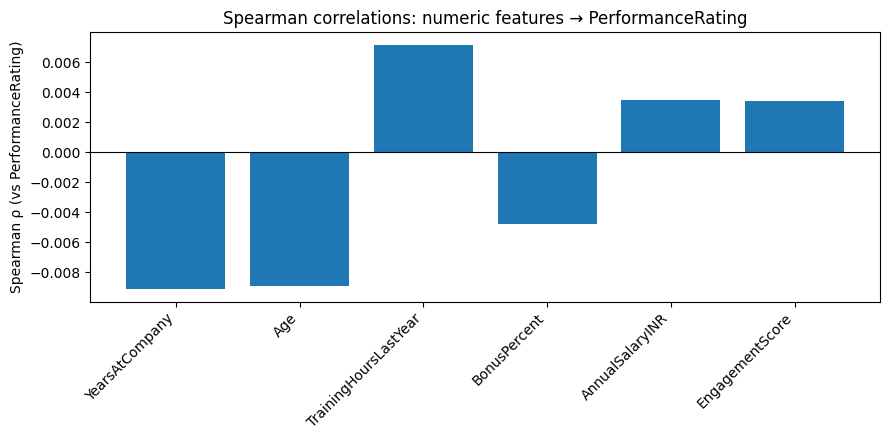

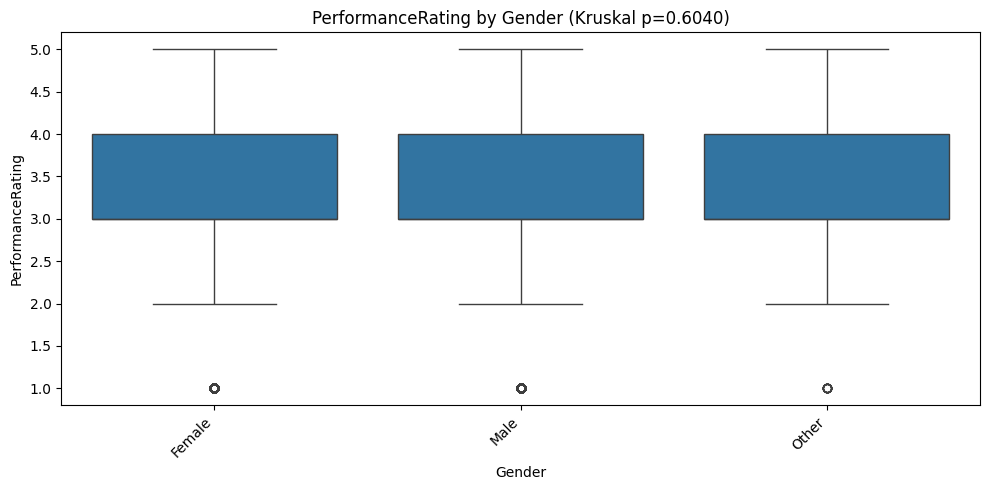

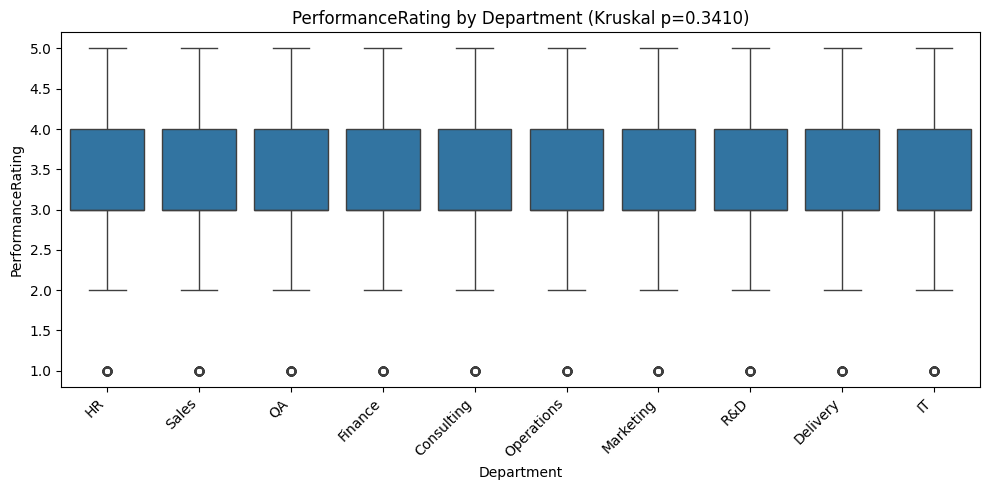

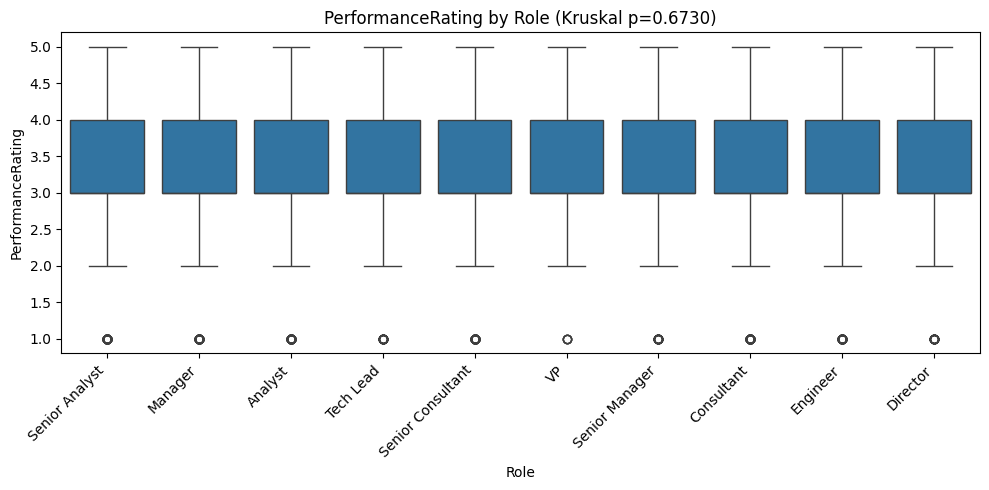

In [4]:
# Q3_visualizations.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_score
from sklearn.inspection import permutation_importance

# Ensure output directory exists
OUT_DIR = "plots"
os.makedirs(OUT_DIR, exist_ok=True)


def safe_fill_numeric(df, cols, fill=-1):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = df[c].fillna(fill)
    return df


def plot_spearman_correlations(df, numeric_feats, save=True):
    """Bar chart of Spearman correlation vs PerformanceRating."""
    rows = []
    for f in numeric_feats:
        if f not in df.columns:
            continue
        rho, p = spearmanr(df[f], df['PerformanceRating'], nan_policy='omit')
        rows.append((f, rho, p))

    rows = sorted(rows, key=lambda x: abs(x[1]), reverse=True)
    labels = [r[0] for r in rows]
    vals = [r[1] for r in rows]

    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax.bar(range(len(labels)), vals)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("Spearman ρ (vs PerformanceRating)")
    ax.set_title("Spearman correlations: numeric features → PerformanceRating")
    plt.tight_layout()
    if save:
        fname = os.path.join(OUT_DIR, "q3_spearman_correlations.png")
        fig.savefig(fname, dpi=150)
        print("Saved:", fname)
    return fig, rows


def plot_kruskal_boxplots(df, categorical_feats, numeric='PerformanceRating', save=True):
    """
    For each categorical feature, produce a boxplot of numeric by category
    and print Kruskal-Wallis p-value.
    """
    figs = {}
    for c in categorical_feats:
        if c not in df.columns:
            continue
        # prepare groups for test
        groups = [grp[numeric].dropna().values for _, grp in df.groupby(c)]
        try:
            stat, p = kruskal(*groups)
        except Exception:
            stat, p = (np.nan, np.nan)

        fig, ax = plt.subplots(figsize=(10, 5))
        sns.boxplot(x=c, y=numeric, data=df, ax=ax)
        ax.set_title(f"{numeric} by {c} (Kruskal p={p:.4f})")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        if save:
            fname = os.path.join(OUT_DIR, f"q3_boxplot_{c}.png")
            fig.savefig(fname, dpi=150)
            print("Saved:", fname)
        figs[c] = (fig, p)
    return figs


def build_q3_models(df, num_feats, cat_feats, test_size=0.25, random_state=42):
    """
    Build a standard preprocessor, train Logistic Regression and RandomForest on high_perf target.
    Returns (pipe_log, pipe_rf, X_test, y_test, feature_names)
    """
    df = df.copy()
    # create binary target: high_perf (PerformanceRating >= 4)
    df['high_perf'] = (df['PerformanceRating'] >= 4).astype(int)

    # ensure numeric fill
    df = safe_fill_numeric(df, num_feats, fill=-1)

    X = df[num_feats + [c for c in cat_feats if c in df.columns]].copy()
    y = df['high_perf'].copy()

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    # preprocessor
    num_in_model = [c for c in num_feats if c in X.columns]
    cat_in_model = [c for c in cat_feats if c in X.columns]

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_in_model),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_in_model)
    ], remainder='drop')

    # logistic pipeline
    log_pipe = Pipeline([('pre', preprocessor),
                         ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga'))])
    log_pipe.fit(X_train, y_train)

    # random forest pipeline
    rf_pipe = Pipeline([('pre', preprocessor),
                        ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=random_state, n_jobs=1))])
    rf_pipe.fit(X_train, y_train)

    # feature names (safe)
    try:
        # after fitting preprocessor on training set inside pipelines, extract feature names:
        # get transformer from pipe
        transformer = log_pipe.named_steps['pre']
        num_names = num_in_model
        cat_names = list(transformer.named_transformers_['cat'].get_feature_names_out(cat_in_model)) if cat_in_model else []
        feature_names = num_names + cat_names
    except Exception:
        feature_names = num_in_model

    return log_pipe, rf_pipe, X_test, y_test, feature_names


def plot_roc_curves(models, X_test, y_test, labels=None, save=True):
    """
    models: list of fitted pipelines with predict_proba
    labels: list of labels (strings) for legend
    """
    plt.figure(figsize=(8, 6))
    for i, m in enumerate(models):
        try:
            probs = m.predict_proba(X_test)[:, 1]
        except Exception:
            # try thresholded predictions fallback (not ideal)
            probs = m.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        lab = labels[i] if labels and i < len(labels) else f"Model {i}"
        plt.plot(fpr, tpr, label=f"{lab} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (High Perf models)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    if save:
        fname = os.path.join(OUT_DIR, "q3_roc_curves.png")
        plt.savefig(fname, dpi=150)
        print("Saved:", fname)
    return plt.gcf()


def plot_permutation_importance(pipe, X_test, y_test, feature_names, top_n=20, save=True):
    """
    Compute and plot permutation importance for a fitted pipeline (expects predict method)
    Uses sklearn.inspection.permutation_importance.
    """
    try:
        result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)
    except Exception as e:
        print("Permutation importance failed:", e)
        return None

    importances = result.importances_mean
    sorted_idx = np.argsort(importances)[::-1][:top_n]
    names = [feature_names[i] if i < len(feature_names) else f"f{i}" for i in sorted_idx]
    vals = importances[sorted_idx]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(range(len(names))[::-1], vals[::-1])
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names[::-1])
    ax.set_xlabel("Permutation importance (mean)")
    ax.set_title("Permutation importance (top {})".format(top_n))
    plt.tight_layout()
    if save:
        fname = os.path.join(OUT_DIR, "q3_permutation_importance.png")
        fig.savefig(fname, dpi=150)
        print("Saved:", fname)
    return fig, result


def plot_training_tenure_heatmap(df, n_bins=6, save=True):
    """
    Heatmap of avg PerformanceRating across binned YearsAtCompany (rows) and TrainingHoursLastYear (cols).
    """
    df2 = df.copy()
    # clip negatives and NaNs (sensible bins)
    df2['train_clipped'] = pd.cut(df2['TrainingHoursLastYear'].fillna(0).clip(lower=0), bins=n_bins)
    df2['tenure_clipped'] = pd.cut(df2['YearsAtCompany'].fillna(0).clip(lower=0), bins=n_bins)

    heat = df2.groupby(['tenure_clipped', 'train_clipped']).agg(avg_perf=('PerformanceRating', 'mean'),
                                                                count=('EmployeeID', 'count')).reset_index()
    pivot = heat.pivot(index='tenure_clipped', columns='train_clipped', values='avg_perf')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cbar_kws={'label': 'Avg PerformanceRating'}, ax=ax)
    ax.set_title("Avg PerformanceRating: YearsAtCompany (rows) vs TrainingHours (cols)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        fname = os.path.join(OUT_DIR, "q3_training_tenure_heatmap.png")
        fig.savefig(fname, dpi=150)
        print("Saved:", fname)
    return fig, pivot


def produce_all_q3_plots(df):
    """
    End-to-end: produce and save all Q3 visualizations.
    Returns dictionary of produced objects for further use.
    """
    outputs = {}

    # numeric features to check vs PerformanceRating (tweak as needed)
    numeric_feats = ['TrainingHoursLastYear', 'YearsAtCompany', 'AnnualSalaryINR', 'BonusPercent', 'EngagementScore', 'Age']
    categorical_feats = ['Gender', 'Location_Clean', 'Department', 'Role']

    # 1) Spearman correlations
    fig_sp, spearman_rows = plot_spearman_correlations(df, numeric_feats, save=True)
    outputs['spearman'] = spearman_rows

    # 2) Kruskal boxplots for categorical features
    box_figs = plot_kruskal_boxplots(df, categorical_feats, numeric='PerformanceRating', save=True)
    outputs['boxplots'] = box_figs

    # 3) Train models (logistic + RF) and get test split
    # Keep the features leakage-free as used elsewhere
    num_feats_model = ['TrainingHoursLastYear', 'YearsAtCompany', 'AnnualSalaryINR', 'BonusPercent', 'EngagementScore', 'Age']
    cat_feats_model = ['Gender', 'Location_Clean', 'Department', 'Role']
    log_pipe, rf_pipe, X_test, y_test, feature_names = build_q3_models(df, num_feats_model, cat_feats_model)

    outputs['models'] = {'log_pipe': log_pipe, 'rf_pipe': rf_pipe}

    # 4) ROC curves
    roc_fig = plot_roc_curves([log_pipe, rf_pipe], X_test, y_test, labels=['Logistic', 'RandomForest'], save=True)
    outputs['roc'] = roc_fig

    # 5) Permutation importance for RF (works on full pipeline)
    perm_fig_res = None
    try:
        perm_fig_res = plot_permutation_importance(rf_pipe, X_test, y_test, feature_names, top_n=20, save=True)
    except Exception as e:
        print("Permutation importance plotting error:", e)
    outputs['perm_importance'] = perm_fig_res

    # 6) Training vs Tenure heatmap
    heat_fig, pivot = plot_training_tenure_heatmap(df, n_bins=6, save=True)
    outputs['heatmap'] = {'fig': heat_fig, 'pivot': pivot}

    print("All Q3 plots produced and saved to", OUT_DIR)
    return outputs


# If running as a script, you can call produce_all_q3_plots(df)
if __name__ == "__main__":
    # Example usage: load df first and then:
    df = pd.read_excel("Cogentix_Case.xlsx")  # or load your prepared df
    produce_all_q3_plots(df)
    pass


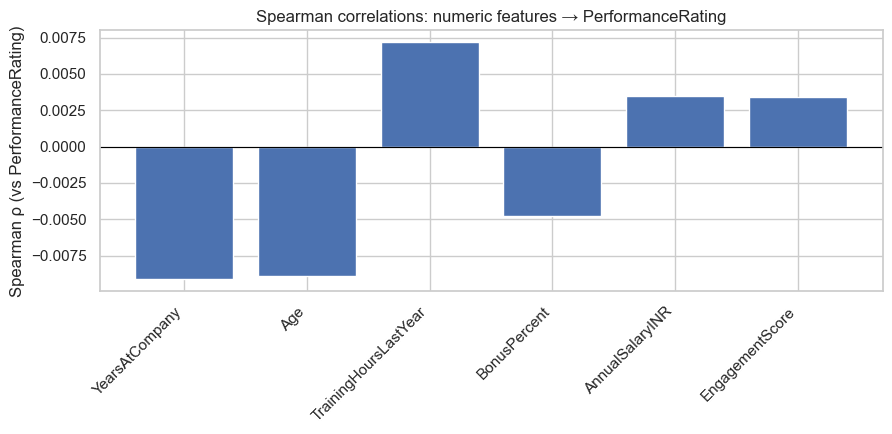

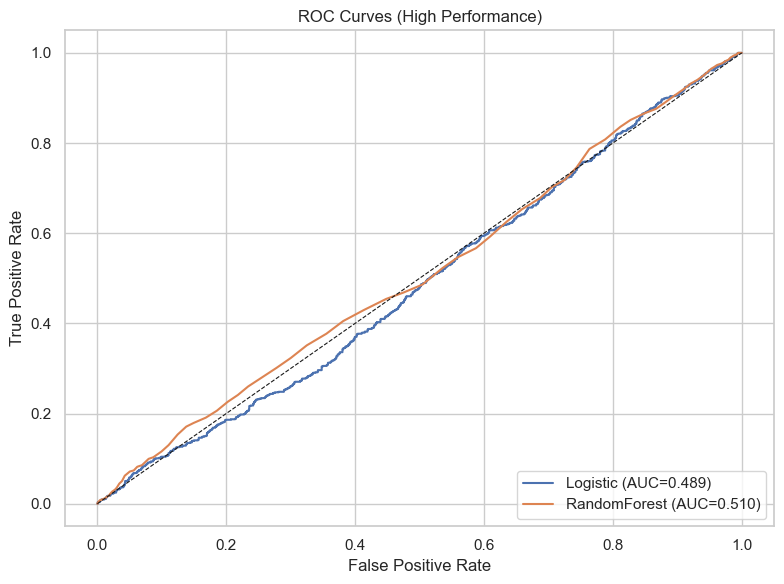

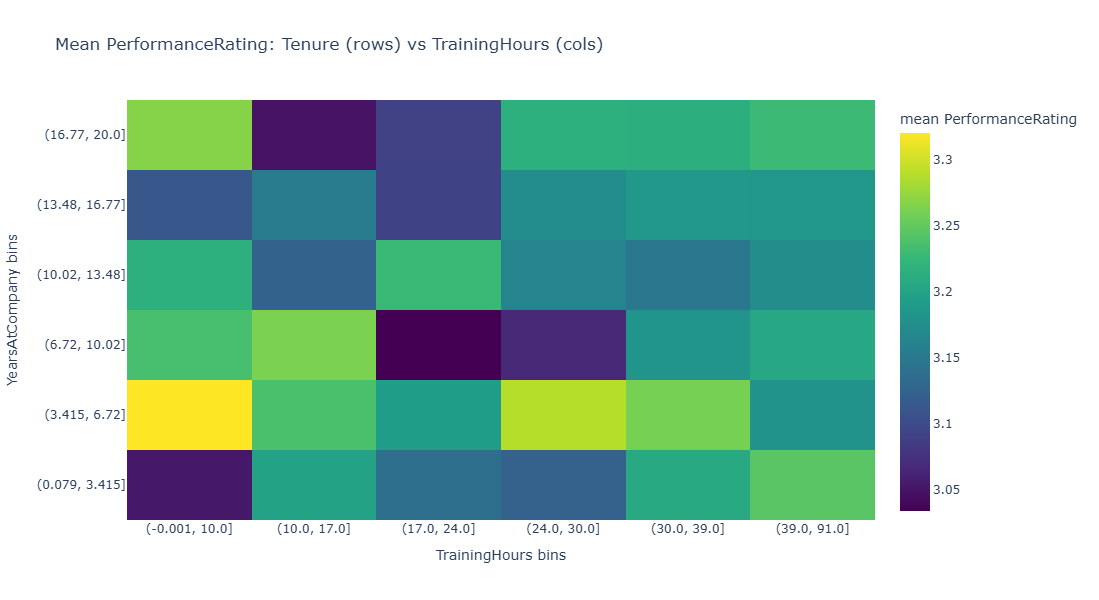

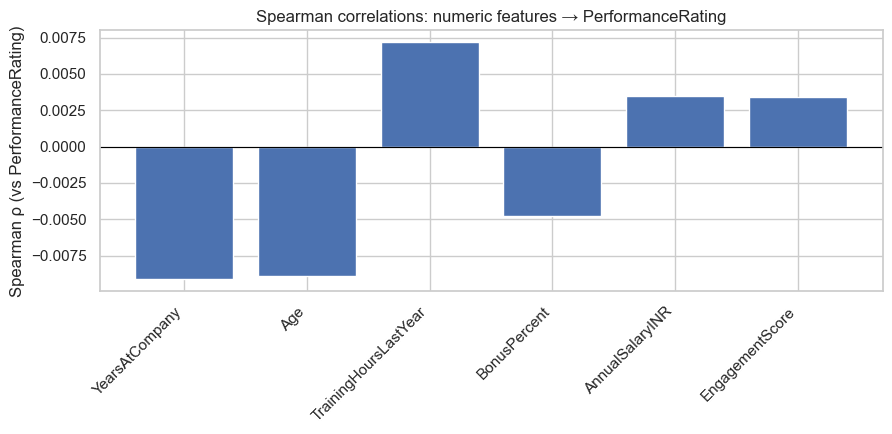

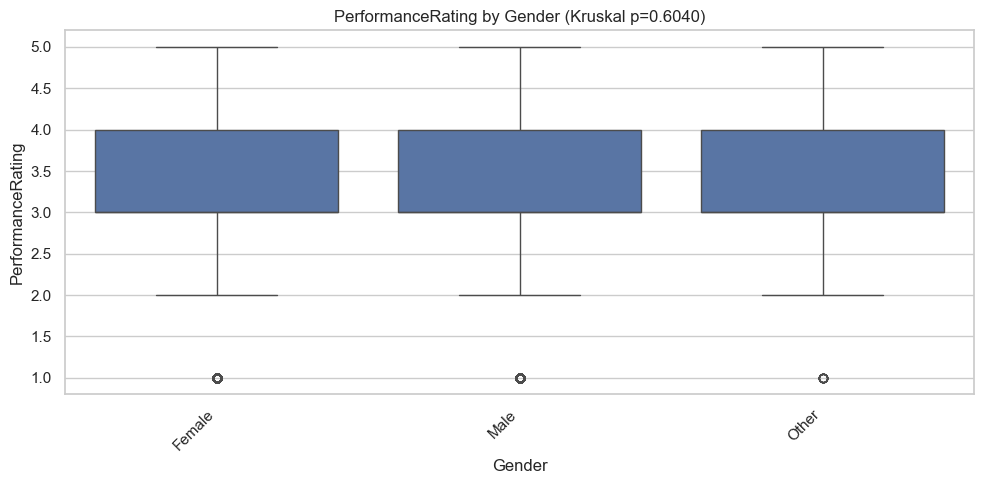

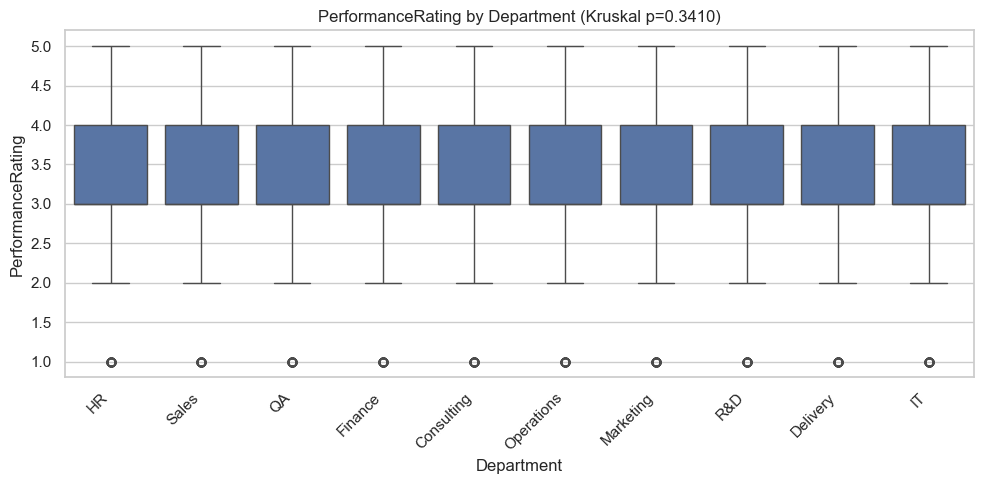

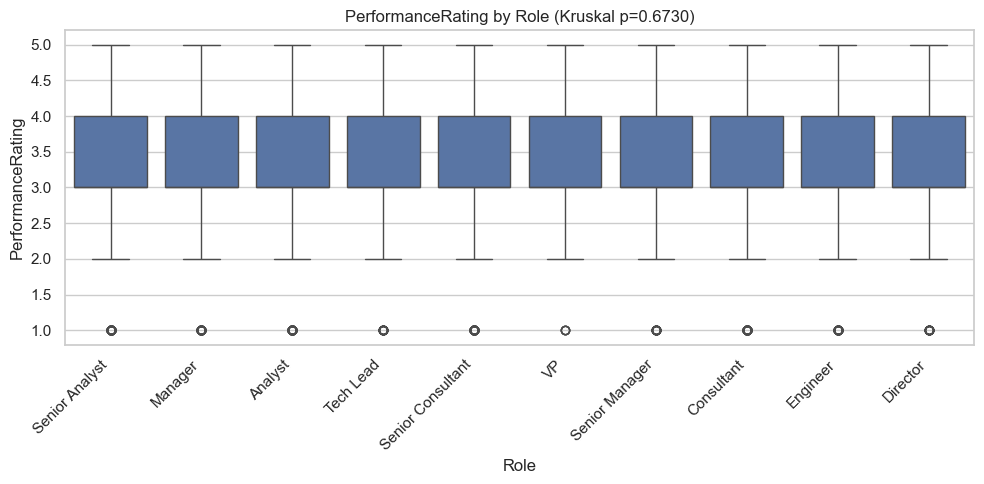

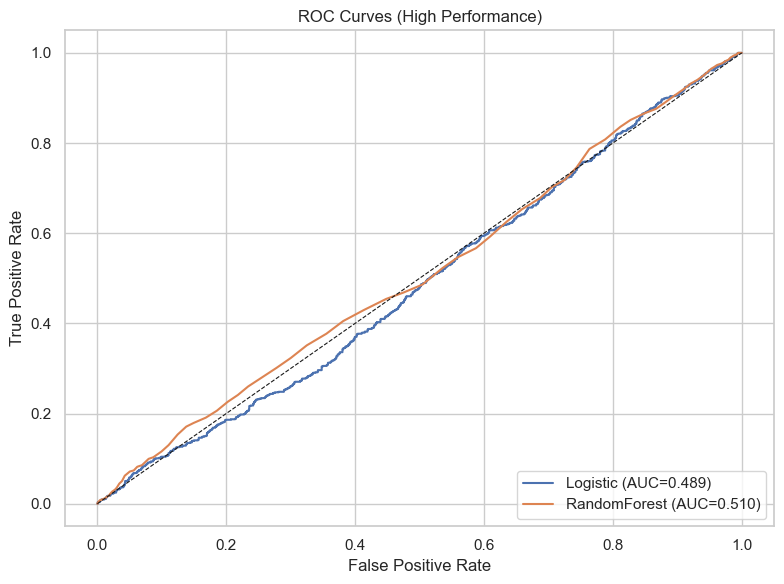

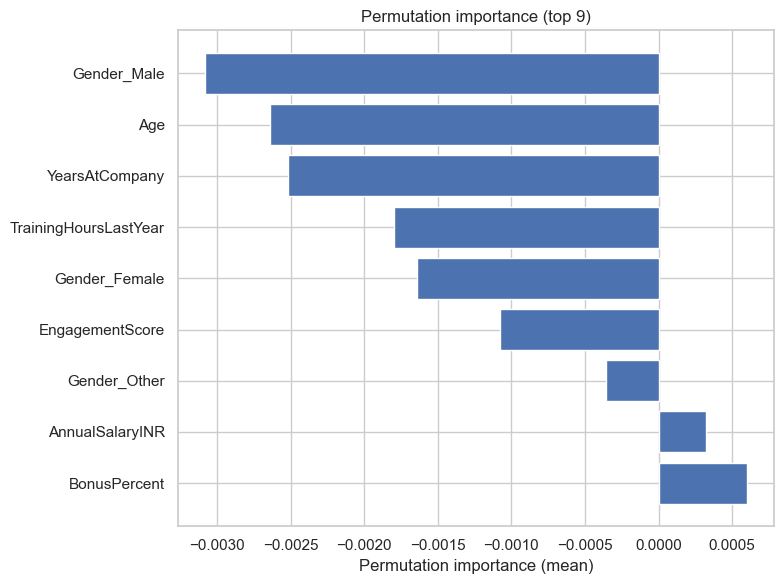

In [ ]:
# q3_performance_visualizations.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_score, classification_report
from sklearn.inspection import permutation_importance
import plotly.express as px
import plotly.graph_objects as go

sns.set(style="whitegrid")


def compute_spearman(df, numeric_feats, target='PerformanceRating'):
    """Return list of tuples (feature, rho, pvalue) sorted by |rho| desc."""
    rows = []
    for f in numeric_feats:
        if f not in df.columns:
            continue
        # drop missing in either series
        x = df[f]
        y = df[target]
        try:
            rho, p = spearmanr(x, y, nan_policy='omit')
        except Exception:
            rho, p = (np.nan, np.nan)
        rows.append((f, float(rho) if np.isfinite(rho) else np.nan, float(p) if np.isfinite(p) else np.nan))
    rows = sorted(rows, key=lambda r: abs(r[1]) if not np.isnan(r[1]) else -1, reverse=True)
    return rows


def plot_spearman_bar(df, numeric_feats, target='PerformanceRating', figsize=(9,4.5)):
    """Plot Spearman rho bar chart; returns (fig, ax, rows)."""
    rows = compute_spearman(df, numeric_feats, target=target)
    labels = [r[0] for r in rows]
    vals = [r[1] for r in rows]

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(range(len(labels)), vals)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("Spearman ρ (vs {})".format(target))
    ax.set_title("Spearman correlations: numeric features → {}".format(target))
    plt.tight_layout()
    return fig, ax, rows


def plot_category_boxplots(df, categorical_feats, numeric='PerformanceRating', figsize=(10,5)):
    """
    Create boxplots for each categorical feature showing distribution of numeric (PerformanceRating).
    Returns dict: {cat: (fig, ax, pvalue)} where pvalue is Kruskal-Wallis p.
    """
    out = {}
    for c in categorical_feats:
        if c not in df.columns:
            continue
        groups = [g[numeric].dropna().values for _, g in df.groupby(c)]
        try:
            stat, p = kruskal(*groups)
        except Exception:
            stat, p = (np.nan, np.nan)

        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(x=c, y=numeric, data=df, ax=ax)
        ax.set_title(f"{numeric} by {c} (Kruskal p={p:.4f})")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        out[c] = (fig, ax, p)
    return out


def build_models_for_performance(df, numeric_feats, categorical_feats,
                                 target_col='PerformanceRating', high_perf_threshold=4,
                                 test_size=0.25, random_state=42):
    """
    Build models to predict high_perf = (PerformanceRating >= threshold).
    Returns: (log_pipe, rf_pipe, X_test, y_test, feature_names)
    - log_pipe, rf_pipe: fitted sklearn Pipelines (with preprocessor)
    - X_test: dataframe (original column layout) for evaluation/predict_proba
    - y_test: Series binary target
    - feature_names: list of transformed feature names (approx)
    """
    df = df.copy()
    # create binary target
    df['high_perf'] = (df[target_col] >= high_perf_threshold).astype(int)

    # keep only available features
    num = [c for c in numeric_feats if c in df.columns]
    cat = [c for c in categorical_feats if c in df.columns]

    # fill numeric missing with -1 (safe sentinel)
    df[num] = df[num].fillna(-1)

    X = df[num + cat].copy()
    y = df['high_perf'].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False)
, cat)
    ], remainder='drop')

    log_pipe = Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga'))
    ])
    rf_pipe = Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=random_state, n_jobs=1))
    ])

    log_pipe.fit(X_train, y_train)
    rf_pipe.fit(X_train, y_train)

    # Try to infer feature names after preprocessing (best effort)
    feature_names = []
    try:
        num_names = num
        cat_names = []
        if cat:
            enc = log_pipe.named_steps['pre'].named_transformers_['cat']
            # get_feature_names_out requires scikit-learn >=1.0
            cat_names = list(enc.get_feature_names_out(cat))
        feature_names = num_names + cat_names
    except Exception:
        feature_names = num

    return log_pipe, rf_pipe, X_test, y_test, feature_names


def plot_roc(models, model_labels, X_test, y_test, figsize=(8,6)):
    """
    Plot ROC curves for given fitted models (list), return matplotlib figure.
    models: list of fitted pipelines that support predict_proba
    model_labels: list of labels for legend
    """
    fig, ax = plt.subplots(figsize=figsize)
    for m, lab in zip(models, model_labels):
        try:
            probs = m.predict_proba(X_test)[:,1]
        except Exception:
            # fallback to decision function or predict
            try:
                probs = m.decision_function(X_test)
            except Exception:
                probs = m.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{lab} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], 'k--', linewidth=0.8)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves (High Performance)")
    ax.legend(loc='lower right')
    plt.tight_layout()
    return fig, ax


def compute_and_plot_perm_importance(pipeline, X_test, y_test, feature_names=None, top_n=20, figsize=(8,6)):
    """
    Compute permutation importance for a fitted pipeline and plot top_n.
    Returns (fig, ax, result). result is sklearn's object.
    """
    # permutation_importance expects estimator that supports predict
    result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)
    importances = result.importances_mean
    idx = np.argsort(importances)[::-1][:top_n]
    names = [(feature_names[i] if feature_names and i < len(feature_names) else f"f{i}") for i in idx]
    vals = importances[idx]

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(range(len(names))[::-1], vals[::-1])
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names[::-1])
    ax.set_xlabel("Permutation importance (mean)")
    ax.set_title(f"Permutation importance (top {min(top_n, len(names))})")
    plt.tight_layout()
    return fig, ax, result


def interactive_training_tenure_heatmap(df, tenure_col='YearsAtCompany', training_col='TrainingHoursLastYear',
                                       value_col='PerformanceRating', tenure_bins=6, training_bins=6,
                                       aggfunc='mean'):
    """
    Return Plotly interactive heatmap for binned tenure vs binned training hours,
    cell value = aggregate (mean by default) of value_col (PerformanceRating).
    """
    # prepare binned columns
    s_ten = df[tenure_col].fillna(0).clip(lower=0)
    s_train = df[training_col].fillna(0).clip(lower=0)

    # compute bins
    df2 = df.copy()
    try:
        df2['_tenure_bin'] = pd.qcut(s_ten, q=tenure_bins, duplicates='drop')
    except Exception:
        df2['_tenure_bin'] = pd.cut(s_ten, bins=tenure_bins)

    try:
        df2['_train_bin'] = pd.qcut(s_train, q=training_bins, duplicates='drop')
    except Exception:
        df2['_train_bin'] = pd.cut(s_train, bins=training_bins)

    grouped = df2.groupby(['_tenure_bin', '_train_bin']).agg(
        val = (value_col, aggfunc),
        count = ('EmployeeID' if 'EmployeeID' in df2.columns else df2.index.name, 'count')
    ).reset_index()

    # pivot to heatmap-friendly matrix
    pivot = grouped.pivot(index='_tenure_bin', columns='_train_bin', values='val')

    # labels = string versions of bin ranges for axis ticks
    x_labels = [str(c) for c in pivot.columns]
    y_labels = [str(c) for c in pivot.index]

    z = pivot.values

    fig = go.Figure(data=go.Heatmap(
        z=z,
        x=x_labels,
        y=y_labels,
        colorscale='Viridis',
        colorbar=dict(title=f"{aggfunc} {value_col}")
    ))
    fig.update_layout(
        title=f"{aggfunc.title()} {value_col}: Tenure (rows) vs TrainingHours (cols)",
        xaxis_title="TrainingHours bins",
        yaxis_title="YearsAtCompany bins",
        autosize=True,
        height=600,
    )
    return fig, pivot


# -------------------------
# Convenience end-to-end fn
# -------------------------
def performance_driver_analysis_plots(df):
    """
    End-to-end: compute and produce plots for:
      - Spearman bar
      - category boxplots (Gender, Location_Clean, Department, Role)
      - train logistic & RF; return models and ROC plot
      - permutation importance (RF)
      - interactive heatmap (plotly)
    Returns a dict with figures & model objects.
    """
    outputs = {}

    numeric_feats = ['TrainingHoursLastYear', 'YearsAtCompany', 'AnnualSalaryINR',
                     'BonusPercent', 'EngagementScore', 'Age']
    categorical_feats = ['Gender', 'Location_Clean', 'Department', 'Role']

    # Spearman
    fig_sp, ax_sp, sp_rows = plot_spearman_bar(df, numeric_feats)
    outputs['spearman_fig'] = fig_sp
    outputs['spearman_rows'] = sp_rows

    # Category boxplots
    boxplots = plot_category_boxplots(df, categorical_feats)
    outputs['boxplots'] = boxplots

    # Models
    log_pipe, rf_pipe, X_test, y_test, feat_names = build_models_for_performance(df, numeric_feats, categorical_feats)
    outputs['log_pipe'] = log_pipe
    outputs['rf_pipe'] = rf_pipe
    outputs['X_test'] = X_test
    outputs['y_test'] = y_test
    outputs['feature_names'] = feat_names

    # ROC
    fig_roc, ax_roc = plot_roc([log_pipe, rf_pipe], ['Logistic', 'RandomForest'], X_test, y_test)
    outputs['roc_fig'] = fig_roc

    # Permutation importance (RF pipeline)
    try:
        fig_perm, ax_perm, perm_res = compute_and_plot_perm_importance(rf_pipe, X_test, y_test, feature_names=feat_names, top_n=20)
        outputs['perm_fig'] = fig_perm
        outputs['perm_res'] = perm_res
    except Exception as e:
        outputs['perm_error'] = str(e)

    # Interactive heatmap
    fig_heat, pivot = interactive_training_tenure_heatmap(df)
    outputs['heatmap_fig'] = fig_heat
    outputs['heatmap_pivot'] = pivot

    return outputs


# -------------------------
# Example usage (in notebook)
# -------------------------
df = pd.read_excel("Cogentix_Case.xlsx")  # or load your prepared df
outputs = performance_driver_analysis_plots(df)
display(outputs['spearman_fig'])        # matplotlib figure inline
display(outputs['roc_fig'])
#For interactive heatmap:
outputs['heatmap_fig'].show()


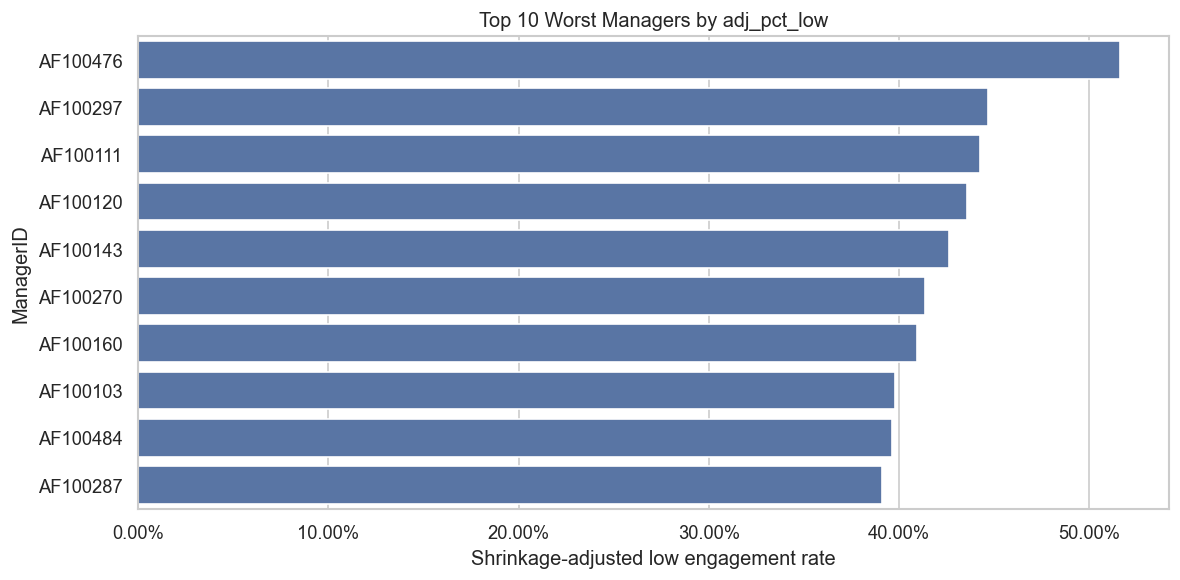

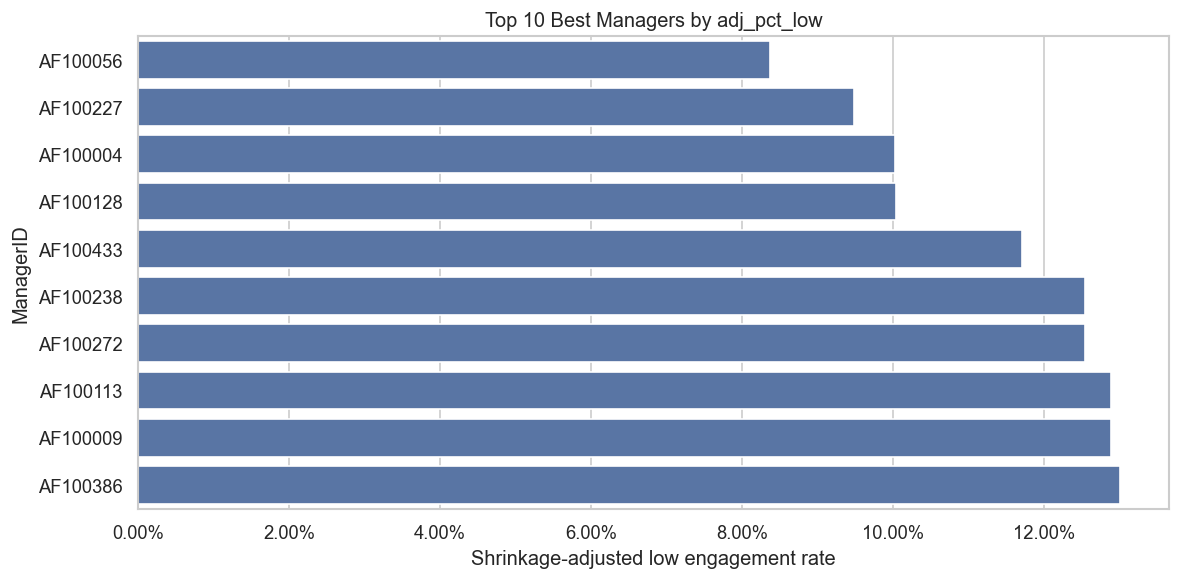

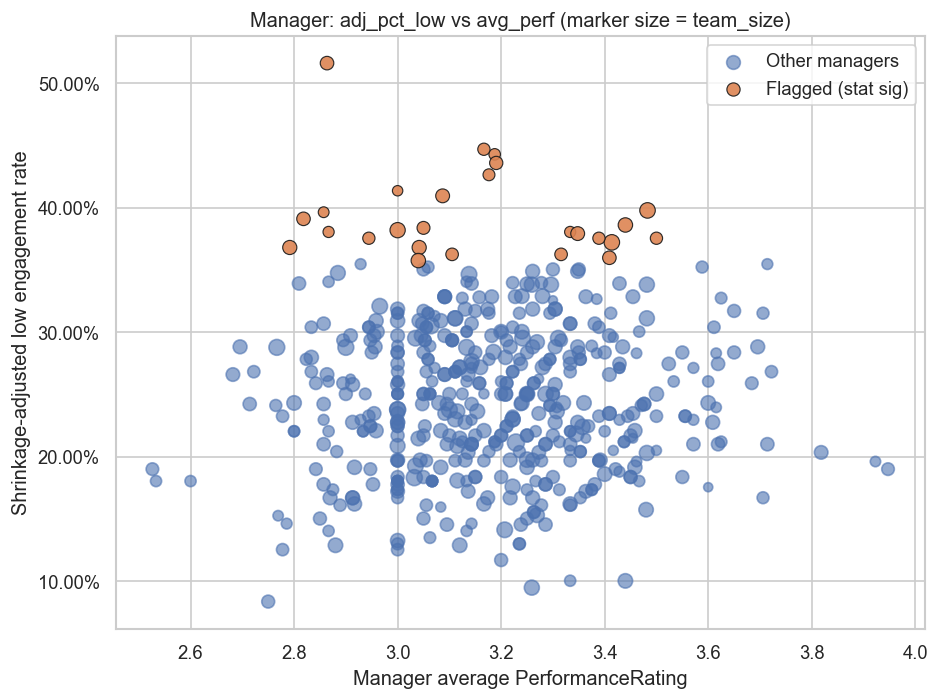

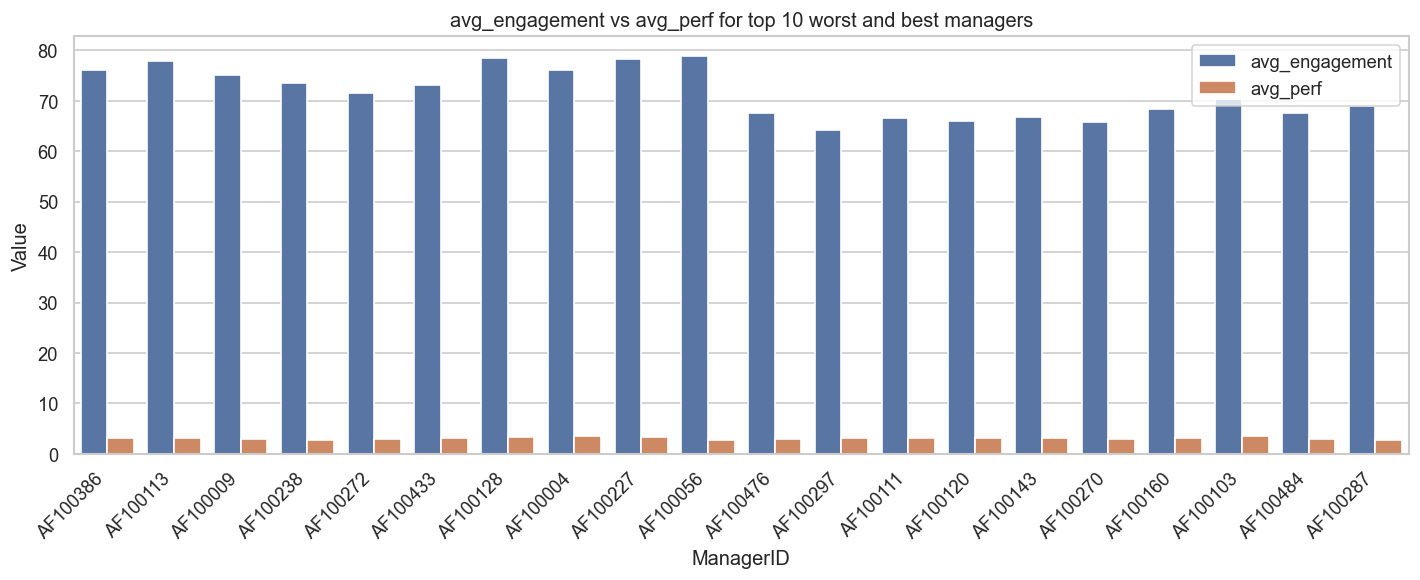

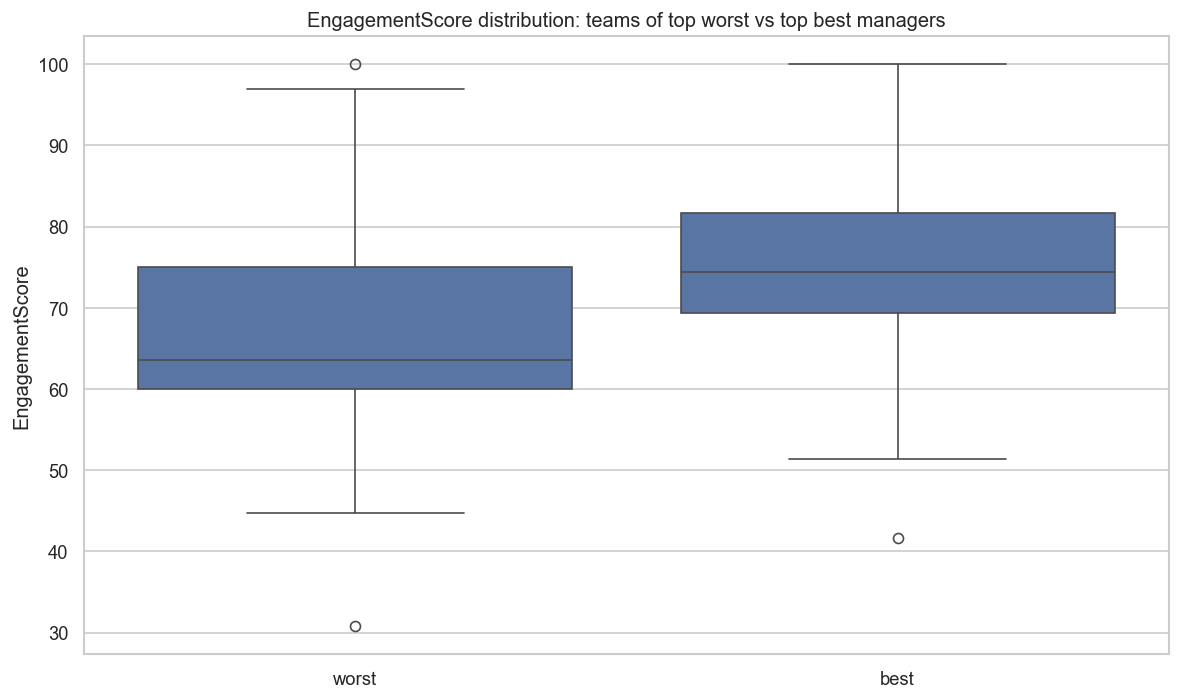

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy.stats import norm

sns.set(style="whitegrid", rc={"figure.dpi":120})

# --- helpers: Wilson CI and one-sided z-test ---
def wilson_ci(x, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    p = x / n
    denom = 1 + z**2 / n
    center = p + z*z/(2*n)
    adj = z * sqrt((p*(1-p) + z*z/(4*n)) / n)
    lo = (center - adj) / denom
    hi = (center + adj) / denom
    return max(0.0, lo), min(1.0, hi)

def one_sided_z_test(x, n, p0):
    if n == 0:
        return (0.0, 1.0)
    phat = x / n
    se = sqrt(p0*(1-p0)/n)
    if se == 0:
        return (0.0, 1.0)
    z = (phat - p0) / se
    # one-sided p-value P(Z > observed z)
    p_one = 1 - norm.cdf(z)
    return z, p_one

# --- main plotting function ---
def manager_impact_plots(df, top_n=10, k_shrink=10, figsize=(10,5)):
    """
    Produces manager impact plots:
    - top_n worst managers (adj_pct_low)
    - top_n best managers (adj_pct_low)
    - scatter adj_pct_low vs avg_perf (size=team_size)
    - grouped bar avg_engagement vs avg_perf for top best/worst
    - boxplots of EngagementScore for teams (best vs worst)
    
    Args:
        df: pandas.DataFrame with columns at least:
            ['EmployeeID','ManagerID','EngagementScore','PerformanceRating']
        top_n: number of best/worst managers to show
        k_shrink: prior strength for empirical-Bayes shrinkage
        figsize: default figure size
    Returns:
        dict of matplotlib.Figure objects {'worst_bar': fig, ...}
    """
    required = {'EmployeeID','ManagerID','EngagementScore','PerformanceRating'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing required columns: {missing}")

    # Aggregate per manager
    mgr = df.groupby('ManagerID', dropna=False).agg(
        team_size=('EmployeeID','count'),
        low_count=('EngagementScore', lambda x: (x <= x.quantile(0.25)).sum()),
        pct_low=('EngagementScore', lambda x: (x <= x.quantile(0.25)).mean()),
        avg_engagement=('EngagementScore','mean'),
        avg_perf=('PerformanceRating','mean'),
        median_engagement=('EngagementScore','median')
    ).reset_index()

    # If you prefer global definition of low_engagement (company-wide q25), do this instead:
    global_q25 = df['EngagementScore'].quantile(0.25)
    df['low_engagement_global'] = (df['EngagementScore'] <= global_q25).astype(int)
    mgr_global = df.groupby('ManagerID', dropna=False).agg(
        team_size=('EmployeeID','count'),
        low_count_global=('low_engagement_global','sum'),
        pct_low_global=('low_engagement_global','mean'),
        avg_engagement=('EngagementScore','mean'),
        avg_perf=('PerformanceRating','mean')
    ).reset_index()
    # prefer global rates (consistent with rest of project)
    mgr = mgr_global.copy()
    global_p = df['low_engagement_global'].mean()

    # Empirical Bayes shrinkage toward global mean
    k = float(k_shrink)
    mgr['adj_pct_low'] = (k*global_p + mgr['team_size']*mgr['pct_low_global'])/(k + mgr['team_size'])

    # Wilson CI and one-sided z-test
    rows = []
    for _, r in mgr.iterrows():
        n = int(r['team_size'])
        x = int(r['low_count_global'])
        lo, hi = wilson_ci(x, n)
        z, p_one = one_sided_z_test(x, n, global_p)
        rows.append((lo, hi, z, p_one))
    rows = np.array(rows)
    mgr['wilson_lo'] = rows[:,0]
    mgr['wilson_hi'] = rows[:,1]
    mgr['z_stat'] = rows[:,2]
    mgr['p_one_sided'] = rows[:,3]
    mgr['flag_worse'] = (mgr['wilson_lo'] > global_p) | (mgr['p_one_sided'] < 0.05)

    # Sort for top lists
    worst = mgr.sort_values('adj_pct_low', ascending=False).head(top_n).copy()
    best  = mgr.sort_values('adj_pct_low', ascending=True).head(top_n).copy()

    # Prepare figure dict to return
    figs = {}

    # 1) Bar chart: top worst
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=worst, x='adj_pct_low', y='ManagerID', ax=ax, orient='h')
    ax.set_xlabel('Shrinkage-adjusted low engagement rate')
    ax.set_ylabel('ManagerID')
    ax.set_title(f'Top {top_n} Worst Managers by adj_pct_low')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.2%}"))
    plt.tight_layout()
    figs['worst_bar'] = fig

    # 2) Bar chart: top best
    fig2, ax2 = plt.subplots(figsize=figsize)
    sns.barplot(data=best, x='adj_pct_low', y='ManagerID', ax=ax2, orient='h')
    ax2.set_xlabel('Shrinkage-adjusted low engagement rate')
    ax2.set_ylabel('ManagerID')
    ax2.set_title(f'Top {top_n} Best Managers by adj_pct_low')
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.2%}"))
    plt.tight_layout()
    figs['best_bar'] = fig2

    # 3) Scatter: adj_pct_low vs avg_perf (size=team_size), highlight flagged managers
    fig3, ax3 = plt.subplots(figsize=(8,6))
    # Merge flags for easy plotting
    mgr_plot = mgr.copy()
    mgr_plot['flag_color'] = mgr_plot['flag_worse'].map({True: 'flagged', False:'normal'})
    # Plot normal
    normal = mgr_plot[~mgr_plot['flag_worse']]
    flagged = mgr_plot[mgr_plot['flag_worse']]
    sc1 = ax3.scatter(normal['avg_perf'], normal['adj_pct_low'], 
                      s=np.clip(normal['team_size']*3, 10, 400), alpha=0.6, label='Other managers')
    sc2 = ax3.scatter(flagged['avg_perf'], flagged['adj_pct_low'], 
                      s=np.clip(flagged['team_size']*3, 20, 500), edgecolor='k', linewidth=0.7, alpha=0.9, label='Flagged (stat sig)')
    ax3.set_xlabel('Manager average PerformanceRating')
    ax3.set_ylabel('Shrinkage-adjusted low engagement rate')
    ax3.set_title('Manager: adj_pct_low vs avg_perf (marker size = team_size)')
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.2%}"))
    ax3.legend()
    plt.tight_layout()
    figs['scatter_adj_vs_perf'] = fig3

    # 4) Grouped bar: avg_engagement vs avg_perf for worst & best (side-by-side)
    top_concat = pd.concat([worst.assign(group='worst'), best.assign(group='best')], ignore_index=True)
    # keep the order by group then adj_pct_low
    top_concat = top_concat.sort_values(['group','adj_pct_low'], ascending=[True, False])
    melted = top_concat.melt(id_vars=['ManagerID','group','team_size'], value_vars=['avg_engagement','avg_perf'],
                             var_name='metric', value_name='value')
    fig4, ax4 = plt.subplots(figsize=(12,5))
    sns.barplot(data=melted, x='ManagerID', y='value', hue='metric', ax=ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
    ax4.set_ylabel('Value')
    ax4.set_title(f'avg_engagement vs avg_perf for top {top_n} worst and best managers')
    plt.legend(title='')
    plt.tight_layout()
    figs['grouped_avg_eng_perf'] = fig4

    # 5) Boxplots of EngagementScore distributions for teams of worst vs best
    flagged_ids = list(worst['ManagerID'])
    best_ids = list(best['ManagerID'])
    df_plot = df[df['ManagerID'].isin(flagged_ids + best_ids)].copy()
    df_plot['group'] = df_plot['ManagerID'].apply(lambda m: 'worst' if m in flagged_ids else 'best')
    fig5, ax5 = plt.subplots(figsize=(10,6))
    sns.boxplot(data=df_plot, x='group', y='EngagementScore', ax=ax5)
    ax5.set_title('EngagementScore distribution: teams of top worst vs top best managers')
    ax5.set_xlabel('')
    ax5.set_ylabel('EngagementScore')
    plt.tight_layout()
    figs['box_engagement_best_vs_worst'] = fig5

    # Show all plots
    for name, f in figs.items():
        f.show()   # will display inline in notebooks

    return figs, mgr, worst, best

# ----------------------------
# Example usage (in notebook)
# ----------------------------
df = pd.read_excel("Cogentix_Case.xlsx")  # or use your prepared df
figs, mgr_summary, worst10, best10 = manager_impact_plots(df, top_n=10, k_shrink=10)


In [ ]:
df['Gender'].unique()

NameError: name 'df' is not defined